In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# Python aplicado a la Gestión de Carteras

## ANÁLISIS INICIAL DE LOS DATOS DE UN ACTIVO

Antes de analizar los datos de una cartera de activos, vamos a ver cómo se analizan los datos de un solo activo. Para ello vamos a:

* Descarga y visualización de un activo

* Binomio rentabilidad-riesgo
  * Calculo de la rentabilidad diaria
  * Diferencia entre la rentabilidad aritmética y la logarítmica
  * Análisis de los retornos: 
    * ¿Son ruido blanco (independientes entre sí)?
    * ¿Siguen una distribución normal (ruido blanco gaussiano)?

* Análisis de otas medidas del riesgo
  * Calculo del VaR y el CVaR
  * Calculo del Drawdown
  * Otras distribuciones: t-Student para las rentabilidades

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import warnings
import requests

import yfinance as yf
import quandl as ql

import statsmodels.api as sm

from utils import dibuja_covar, dibuja_covar_ax

# print(plt.style.available) #list of available styles
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

### Descarga y visualización de un activo

Primero, descargamos los datos OHLC de Apple de los últimos 6 años para visualizarlos con diferentes herramientas.

In [14]:
data_df = yf.download('AAPL', period='6y', interval='1d')
data_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-12,44.044998,44.340000,43.912498,44.272499,41.864697,101672400
2018-01-16,44.474998,44.847500,44.035000,44.047501,41.651951,118263600
2018-01-17,44.037498,44.812500,43.767502,44.775002,42.339882,137547200
2018-01-18,44.842499,45.025002,44.562500,44.814999,42.377701,124773600
2018-01-19,44.652500,44.895000,44.352501,44.615002,42.188572,129700400


Hacemos un gráfico sencillo de los precios de cierre de las acciones de Apple.

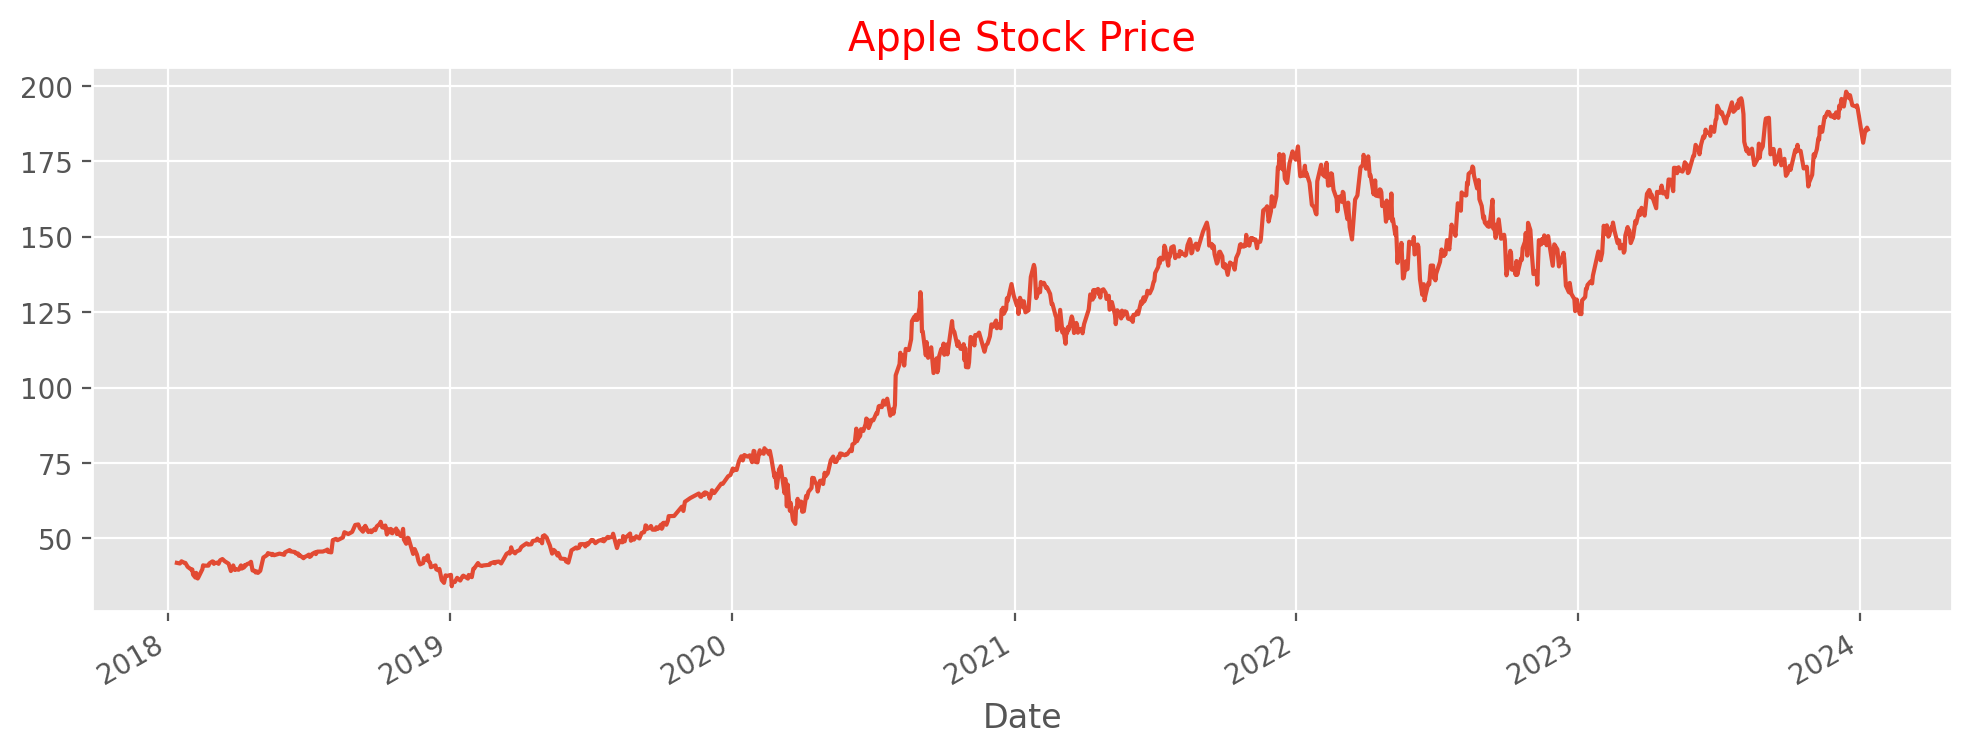

In [15]:
company = 'Apple'
fig, ax = plt.subplots(figsize=(12, 4))
data_df.loc[:, 'Adj Close'].plot(title=f'{company} Stock Price')
plt.show()

Podemos hacer gráficos de velas usando distintas librerías:

Si utilizamos la librería `mplfinance`:

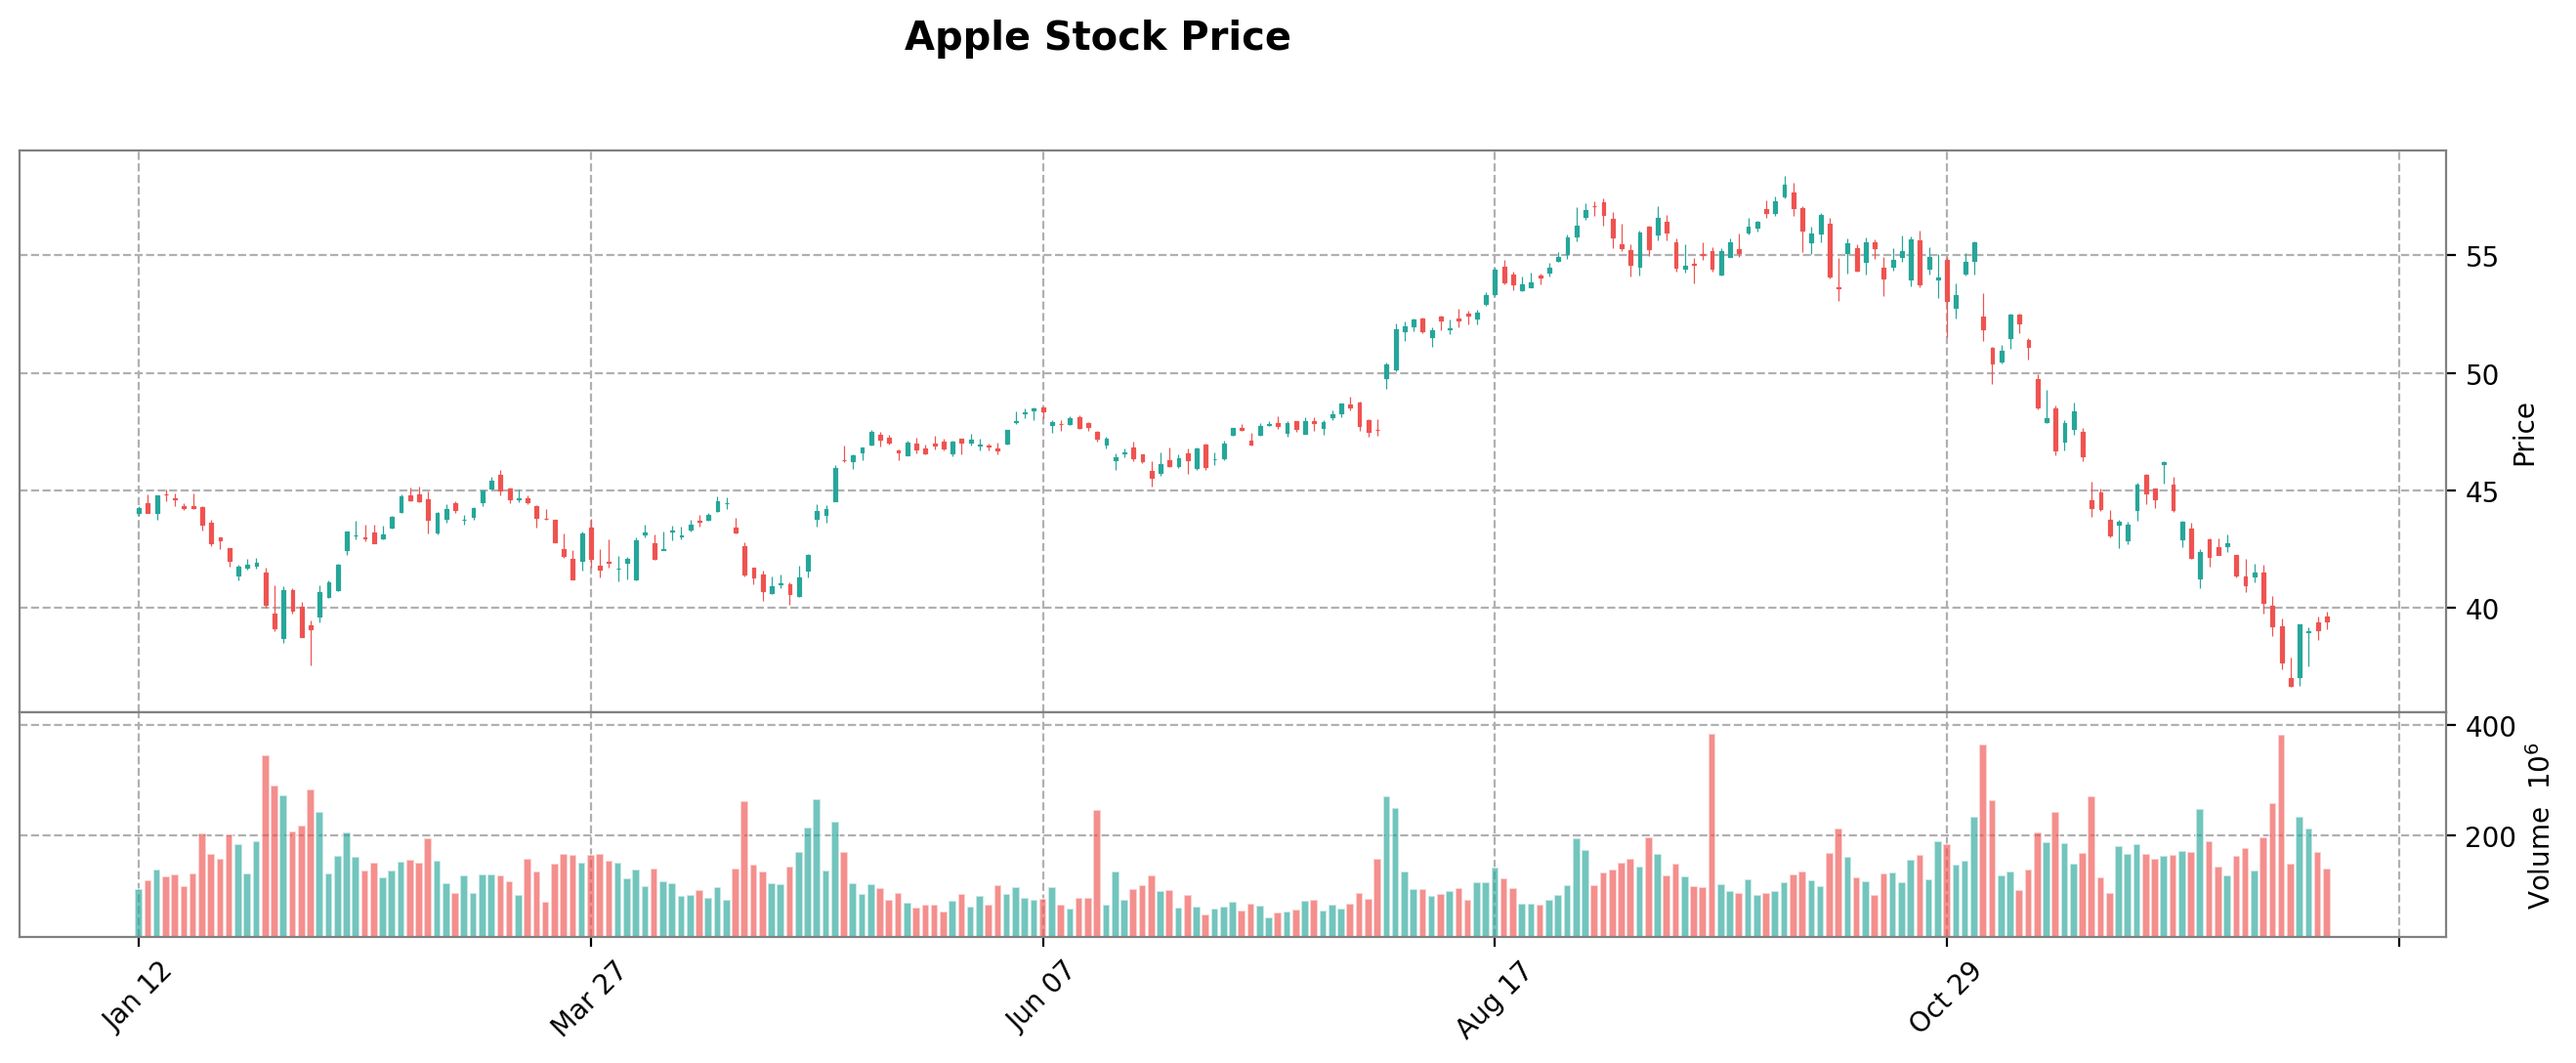

In [18]:
company='Apple'
mpf.plot(data_df.loc["2018"], 
         type='candle', # En el argumento type indicamos que queremos dibujar un gráfico de velas
         volume=True, # El argumento volume indica si queremos representar el volumen
         style='tradingview', # El argumento style nos permite visualizar los datos como en la plataforma TradingView
         figratio=(12, 4),
         title=f'{company} Stock Price')

Si utilizamos la librería `plotly`:

In [19]:
fig = go.Figure(data=[go.Candlestick(x=data_df.loc["2018"].index,
                                     open=data_df.loc["2018"]['Open'],
                                     high=data_df.loc["2018"]['High'],
                                     low=data_df.loc["2018"]['Low'],
                                     close=data_df.loc["2018"]['Close'])
                     ])

fig.update_layout(title = f'{company}: Candlestick Price Chart', xaxis_tickfont_size = 14)
fig.update_layout(xaxis_rangeslider_visible = False)
    
fig.show()

Prueba a pasar el ratón por encima de la figura en una vela en concreto. Puedes ver la información detallada de ese día. También puedes hacer zoom, desplazar la figura, etc.

<hr>

**NOTA CHRIS: AÑADIR EXPLICACION DE POR QUE TRABAJAMOS CON RETORNOS Y NO CON PRECIOS**

### Binomio rentabilidad-riesgo

La teoría financiera siempre ha caracterizado por:

* Los inversores tienen **aversión al riesgo**

* Los activos los representamos por el **binomio rentabilidad-riesgo**: 
        
  - La **rentabilidad** se mide como la media de los retornos
    
  - El **riesgo** se mide a través de la volatilidad, que es la desviación estándar de los rendimientos

Primero calculamos los retornos. Existen dos formas de convertir precios en rendimientos:

**Rendimientos aritméticos:**

$$r_t = \frac{P_t}{P_{t-1}} - 1$$

donde $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

**Rendimientos logarítmicos:**

$$r_t = ln(\frac{P_t}{P_{t-1}}) = ln(P_t) - ln(P_{t-1})$$

donde, como antes, $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

**Observación**: Hay que tener en cuenta las siguientes consideraciones:

* Los rendimientos aritmeticos se pueden sumar entre activos para obtener el rendimiento de la cartera. Los rendimientos logarítmicos no se pueden sumar.

* Los rendimientos logarítmicos se pueden sumar en el tiempo para obtener el rendimiento total del activo. Los rendimientos aritméticos no se pueden sumar.

* Los rendimiento aritméticos siguen una distribución lognormal. Los rendimientos logarítmicos siguen una distribución normal.

* Ambos rendimientos son equivalentes cuando los rendimientos son pequeños. 

<font color="#888800">¿Qué significan suma de retornos logaritmicos y suma de retornos normales? Yo creo que si en la celda siguiente decimos que podemos asumir que son iguales, podemos no decirlo directamente y evitamos confusiones.</font>

Veamos como se comportan los rendimientos aritméticos y logarítmicos para distintos valores de rendimiento:

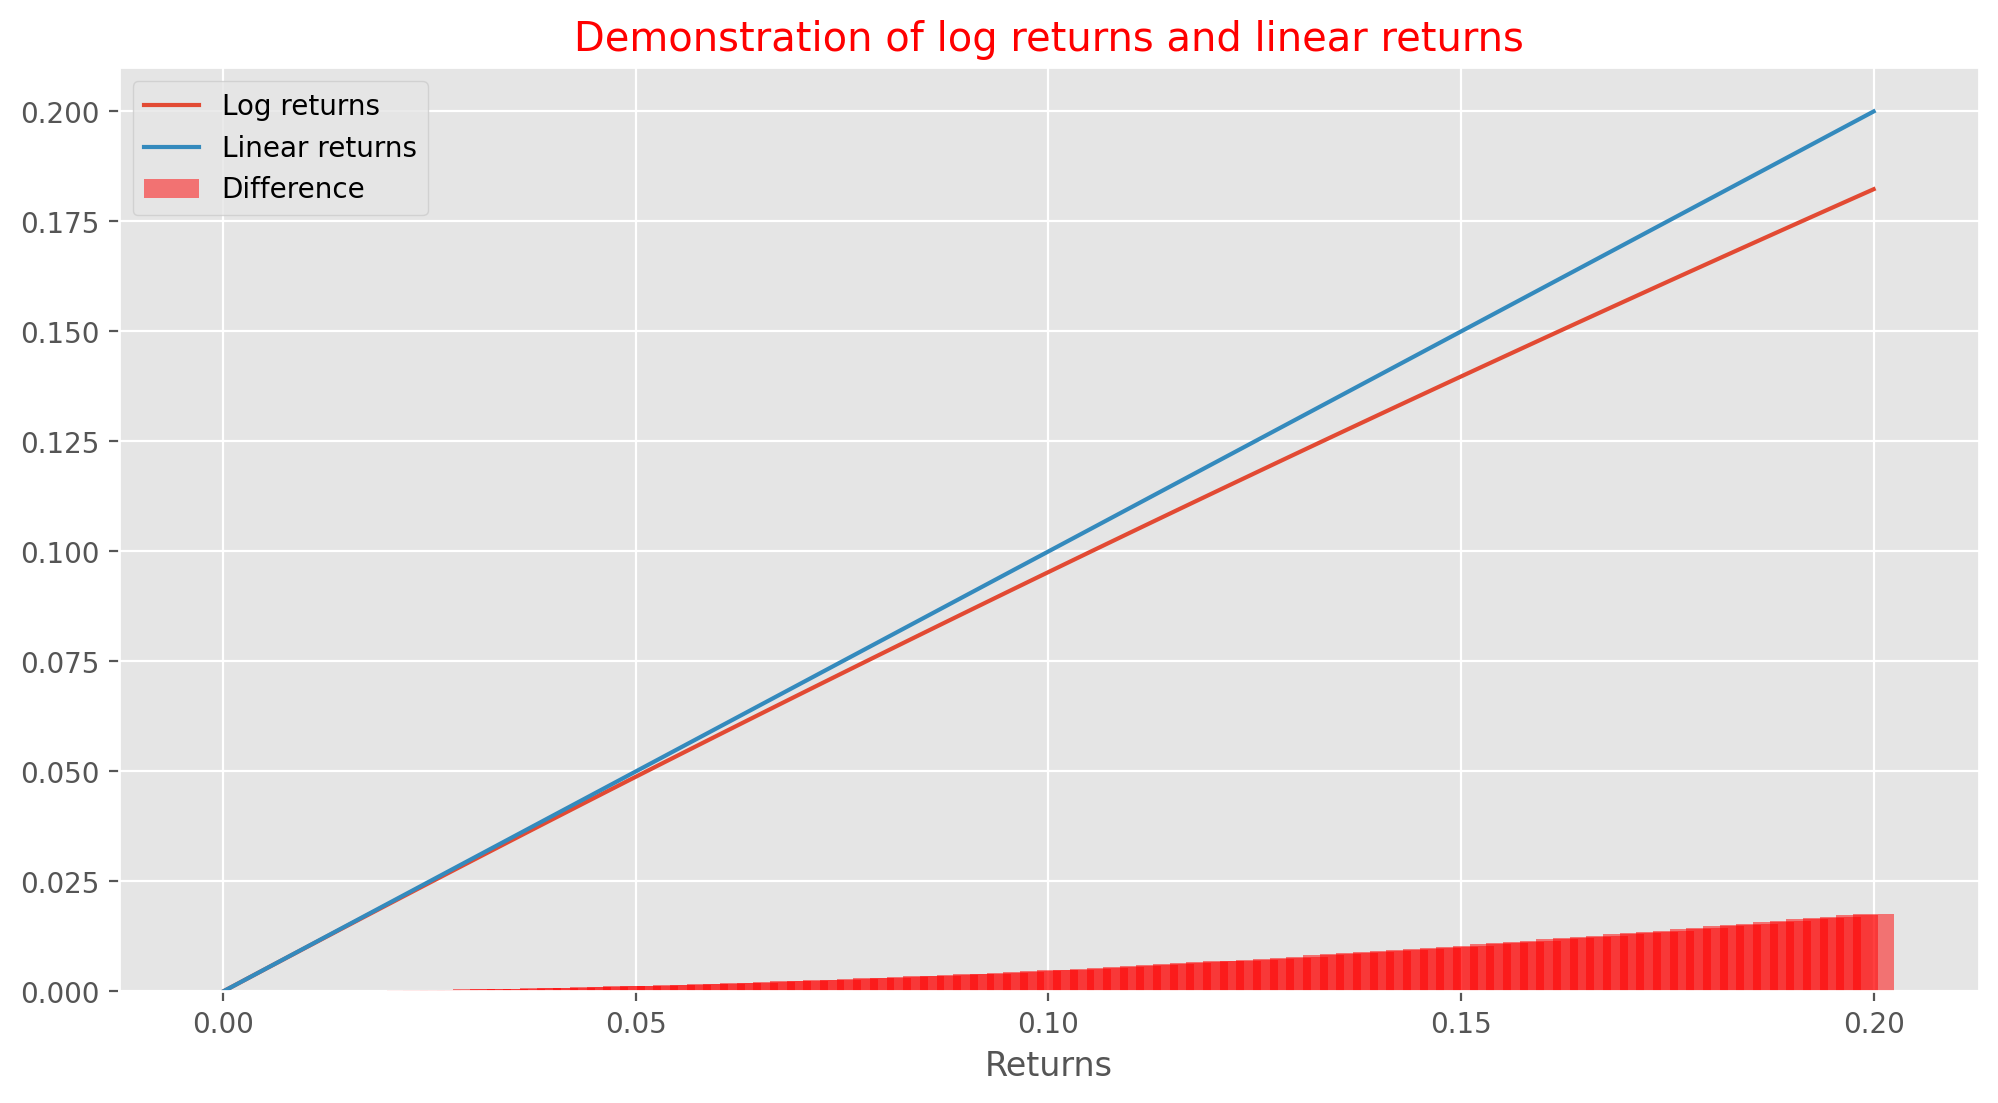

In [20]:
plt.style.use('ggplot')
x_returns = np.linspace(0.0001, .2, 100) # Generate 100 numbers between 0.0001 and 0.2
y_returns = np.log(1 + x_returns) # Calculate the logarithmic returns from the linear returns

# Plot the linear and log returns
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x_returns, y_returns, label='Log returns') # Plot the log returns
plt.plot(x_returns, x_returns, label='Linear returns') # Plot the linear returns
plt.bar(x_returns, x_returns-y_returns, width=0.005, color='r', alpha=0.5, label='Difference', ) # Plot the difference between the two returns
plt.legend()
plt.xlabel('Returns')
plt.title('Demonstration of log returns and linear returns');

Volvemos al dataset anterior con los precios de Apple en los últimos 6 años. Vamos a calcular los retornos aritméticos y logarítmicos:

In [26]:
# Retornos aritméticos
ret_arit = data_df["Adj Close"].pct_change()
ret_arit

Date
2018-01-12         NaN
2018-01-16   -0.005082
2018-01-17    0.016516
2018-01-18    0.000893
2018-01-19   -0.004463
                ...   
2024-01-05   -0.004013
2024-01-08    0.024175
2024-01-09   -0.002263
2024-01-10    0.005671
2024-01-11   -0.003223
Name: Adj Close, Length: 1509, dtype: float64

In [27]:
# Retornos logarítmicos
ret_log = np.log(data_df["Adj Close"]).diff()
ret_log

Date
2018-01-12         NaN
2018-01-16   -0.005095
2018-01-17    0.016381
2018-01-18    0.000893
2018-01-19   -0.004473
                ...   
2024-01-05   -0.004021
2024-01-08    0.023887
2024-01-09   -0.002266
2024-01-10    0.005655
2024-01-11   -0.003228
Name: Adj Close, Length: 1509, dtype: float64

Como véis, son prácticamente iguales. Por tanto, por comodidad en el resto de operaciones, vamos a trabajar con retornos logarítmicos:

In [30]:
ret_df = ret_log.dropna()

Pintemos los retornos para ver el aspecto que tienen:

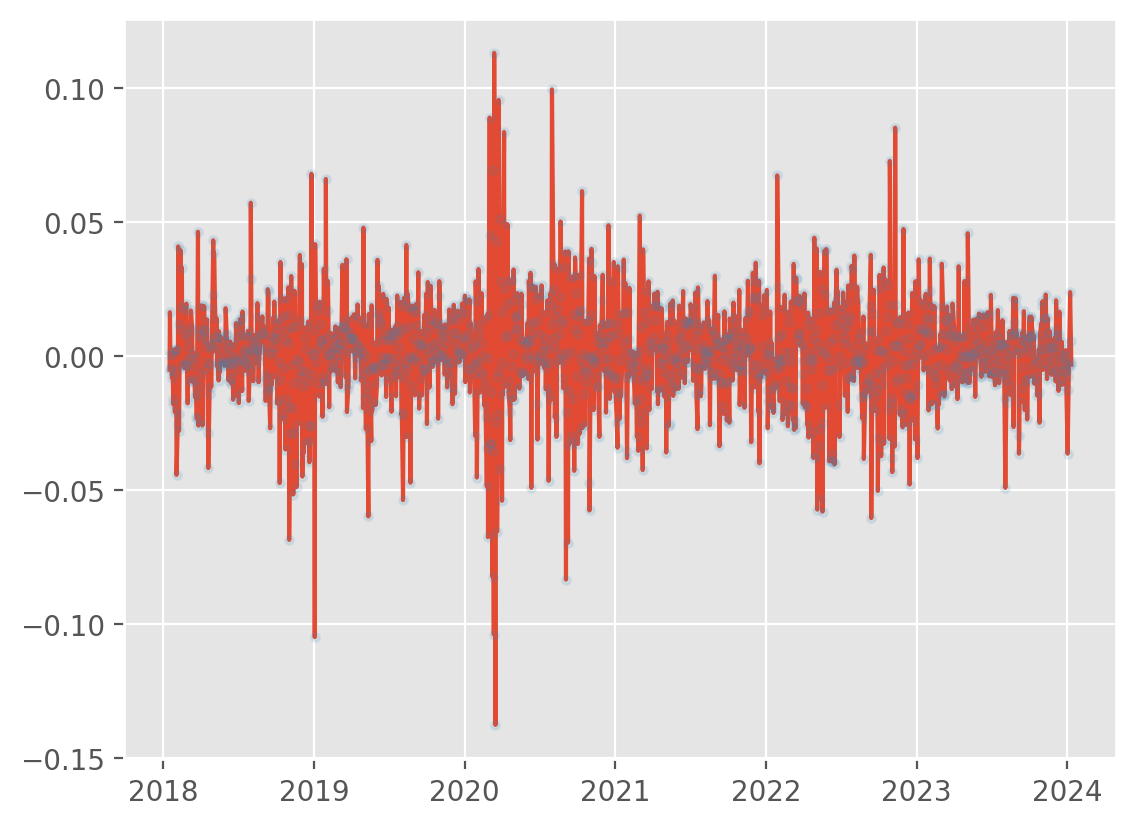

In [39]:
plt.plot(ret_df)
plt.plot(ret_df, '.', alpha=0.1)
plt.show()

Veamos ahora su distribución:

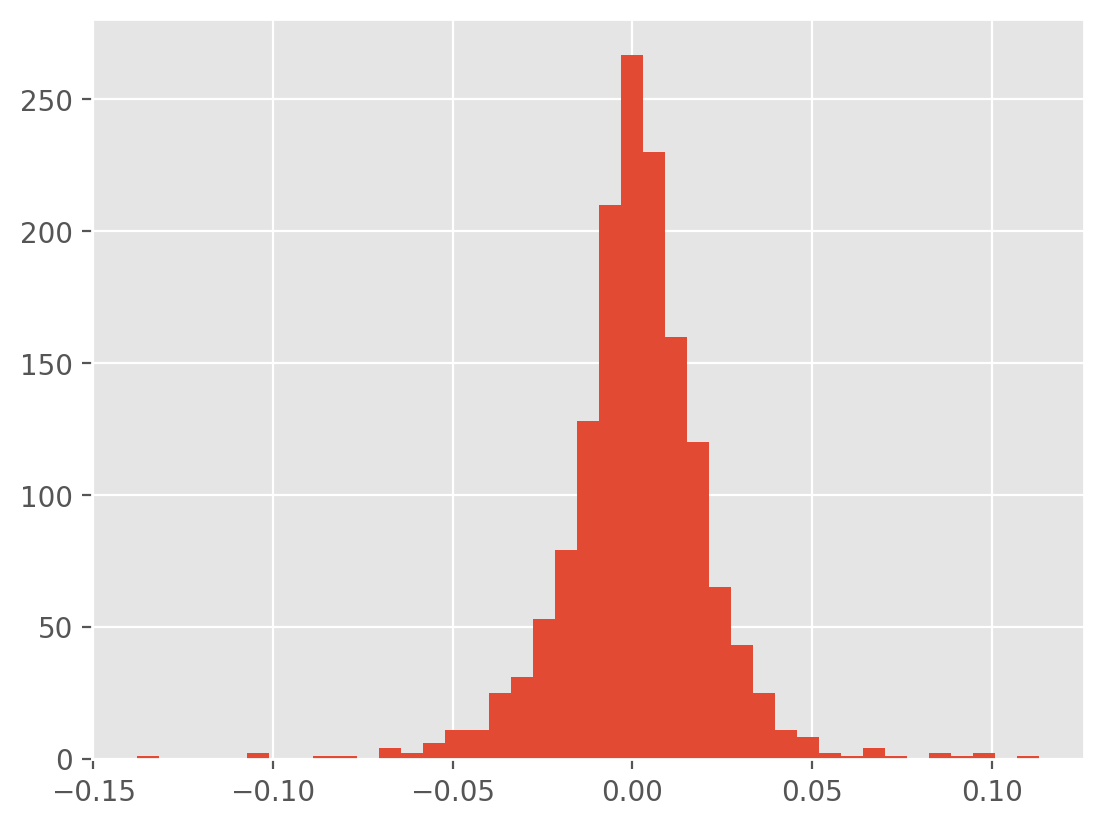

In [42]:
plt.hist(ret_df, bins=41)
plt.show()

Viendo la figura, aparentemente sigue una distribución Normal (Gaussiana). Entonces, podemos caracterizar los datos mediante su media y su desviación estándar:

In [43]:
print(" Media:", ret_df.mean())
print(" Desviación estándar:", ret_df.std())

 Media: 0.0009874648631671803
 Desviación estándar: 0.0199986556154858


Nuestra hipótesis es entonces la siguiente: 

*Los retornos de un activo son ruido blanco Gaussiano, ya que queremos comprobar que son independientes entre sí y, además, siguen una distribución Normal*

A partir de aquí, queremos verificar nuestra hipótesis, es decir, verificar que los retornos son ruido blanco Gaussiano. Para más información sobre el ruido blaco Gaussiano, pincha [aquí](https://es.wikipedia.org/wiki/Ruido_blanco) y [aquí](https://es.wikipedia.org/wiki/Ruido_blanco_gaussiano).

Para ello, primero comprobamos que no tienen autocorrelación y son independientes entre sí. Calculamos la **autocorrelación** y la **autocorrelación parcial** de los retornos y, si los retornos son ruido blanco, la autocorrelación y la autocorrelación parcial deberían ser prácticamente cero. Para más información sobre la autocorrelación y la autocorrelación parcial, pincha [aquí](https://es.wikipedia.org/wiki/Autocorrelaci%C3%B3n).

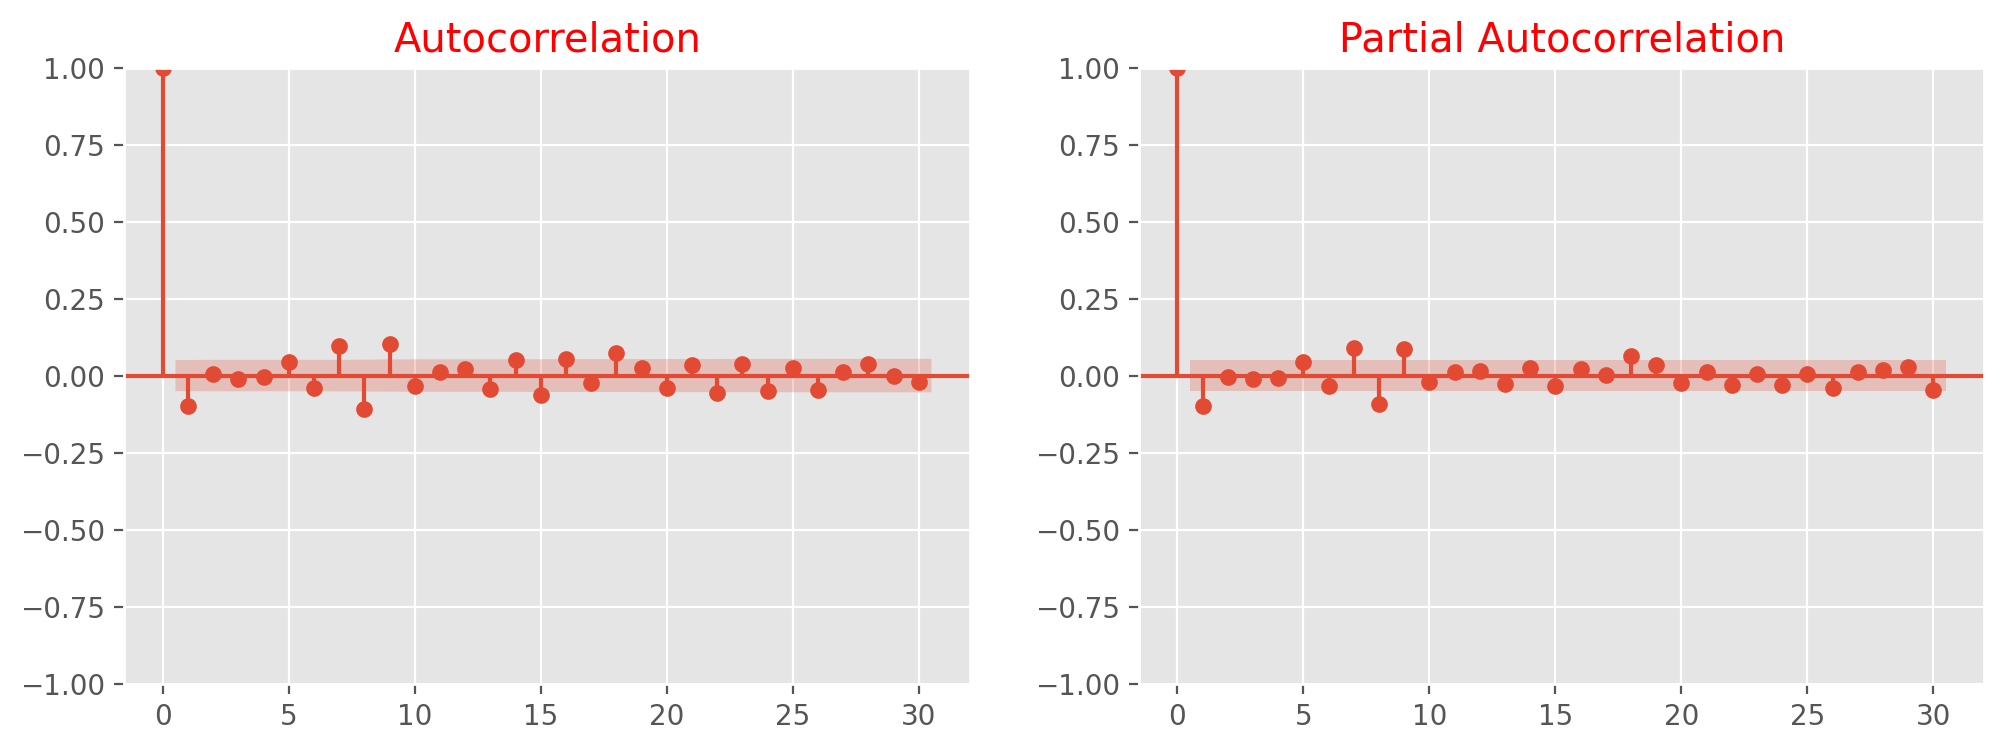

In [44]:
# Calculamos y graficamos PACF y ACF
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ret_df, lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(ret_df, lags=30, ax=ax[1])
plt.show()

Sin embargo, aún no hemos comprobado si los retornos siguen una distribución normal. Aparentemente sí, pero existen varios tests para comprobarlo. Los más conocidos son el test de [Kolmogorov-Smirnov](https://es.wikipedia.org/wiki/Prueba_de_Kolmog%C3%B3rov-Smirnov) y el test de [Shapiro-Wilk](https://es.wikipedia.org/wiki/Prueba_de_Shapiro%E2%80%93Wilk). 

In [45]:
# Prueba de Kolmogorov-Smirnov
stat, p = stats.kstest(ret_df, 'norm')

# Compara el valor p con un nivel de significancia (por ejemplo, 0.05)
alpha = 0.05
if p > alpha:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos SÍ SIGUEN una distribución normal (no podemos rechazar la hipótesis nula)")
else:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)")

El resultado es de 0.0000, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)


Acabamos de comprobar que los retornos de un activo **NO son ruido blanco Gaussiano**. Sin embargo, para poder trabajar con ellos necesitamos simplificar la situación y asumir que, aunque se vayan a cometer errores, siguen una distribución Normal.

Vamos a descargar dos grupos de activos que nos servirán para analizar distintos comportamientos.

In [46]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

In [47]:
data_OHLC_df.head()

Adj Close                                                     \
                 AAPL BTC-USD    ELE.MC        IAU        IEF       TSLA   
Date                                                                       
2013-10-07  15.203007     NaN  5.184735  25.680000  84.856277  12.204667   
2013-10-08  14.990746     NaN  5.180736  25.620001  84.814644  11.648667   
2013-10-09  15.166854     NaN  5.262038  25.340000  84.664726  11.252000   
2013-10-10  15.261921     NaN  5.336677  24.980000  84.481369  11.528667   
2013-10-11  15.360727     NaN  5.343342  24.639999  84.606331  11.913333   

                Close                                ...       Open  \
                 AAPL BTC-USD     ELE.MC        IAU  ...     ELE.MC   
Date                                                 ...              
2013-10-07  17.419643     NaN  19.450001  25.680000  ...  19.360001   
2013-10-08  17.176430     NaN  19.434999  25.620001  ...  19.420000   
2013-10-09  17.378214     NaN  19.740000  25.340000  ...  19.375000   
2013-10-10  17.487143     NaN  20.020000  24.980000  ...  19.825001   
2013-10-11  17.600357     NaN  20.045000  24.639999  ...  20.045000   

                                                   Volume                    \
                  IAU         IEF       TSLA         AAPL BTC-USD    ELE.MC   
Date                                                                          
2013-10-07  25.580000  102.059998  12.164000  312292400.0     NaN  121645.0   
2013-10-08  25.719999  101.800003  12.293333  290917200.0     NaN  143155.0   
2013-10-09  25.379999  101.790001  11.648667  301725200.0     NaN  268379.0   
2013-10-10  25.200001  101.269997  11.539333  278602800.0     NaN  340366.0   
2013-10-11  24.620001  101.690002  11.516667  267738800.0     NaN  173073.0   

                                              
                  IAU       IEF         TSLA  
Date                                          
2013-10-07  2414350.0  454400.0  172284000.0  
2013-10-08  1434200.0  818100.0  206358000.0  
2013-10-09  3605650.0  506500.0  229747500.0  
2013-10-10  3883650.0  649100.0  133258500.0  
2013-10-11  2674950.0  850100.0  124666500.0  

[5 rows x 36 columns]

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [48]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

In [49]:
data_OHLC_df_corr.head()

Adj Close                                                          \
                 AAPL       CSCO         IBM       INTC       MSFT       ORCL   
Date                                                                            
2013-10-07  15.203010  16.748629  115.038887  17.101440  27.885912  28.221779   
2013-10-08  14.990749  16.565710  112.959435  16.839266  27.643059  27.817881   
2013-10-09  15.166852  16.463264  114.602745  16.921661  27.693300  27.663189   
2013-10-10  15.261921  16.836430  116.783310  17.303694  28.271114  28.350683   
2013-10-11  15.360729  17.033991  117.661797  17.423548  28.580963  28.582718   

                Close                                ...        Open  \
                 AAPL       CSCO         IBM   INTC  ...         IBM   
Date                                                 ...               
2013-10-07  17.419643  22.889999  174.005737  22.83  ...  173.852768   
2013-10-08  17.176430  22.639999  170.860428  22.48  ...  173.891006   
2013-10-09  17.378214  22.500000  173.346085  22.59  ...  171.481842   
2013-10-10  17.487143  23.010000  176.644363  23.10  ...  175.114716   
2013-10-11  17.600357  23.280001  177.973236  23.26  ...  177.103256   

                                                Volume                     \
                 INTC       MSFT       ORCL       AAPL      CSCO      IBM   
Date                                                                        
2013-10-07  22.709999  33.599998  32.860001  312292400  29575900  4148854   
2013-10-08  22.870001  33.310001  32.830002  290917200  31865700  5834902   
2013-10-09  22.510000  33.070000  32.450001  301725200  45438300  4626981   
2013-10-10  22.990000  33.310001  32.480000  278602800  38817500  3827209   
2013-10-11  22.830000  33.680000  33.080002  267738800  27773800  3381300   

                                          
                INTC      MSFT      ORCL  
Date                                      
2013-10-07  21321300  35069300  14150100  
2013-10-08  36111200  41017600  23780400  
2013-10-09  40435400  35878600  19656000  
2013-10-10  39189400  42875100  21580700  
2013-10-11  24550600  30033300  14018800  

[5 rows x 36 columns]

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [50]:
data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

Hacemos unas gráficas para ver la rentabilidad y volatilidad de cada activo.

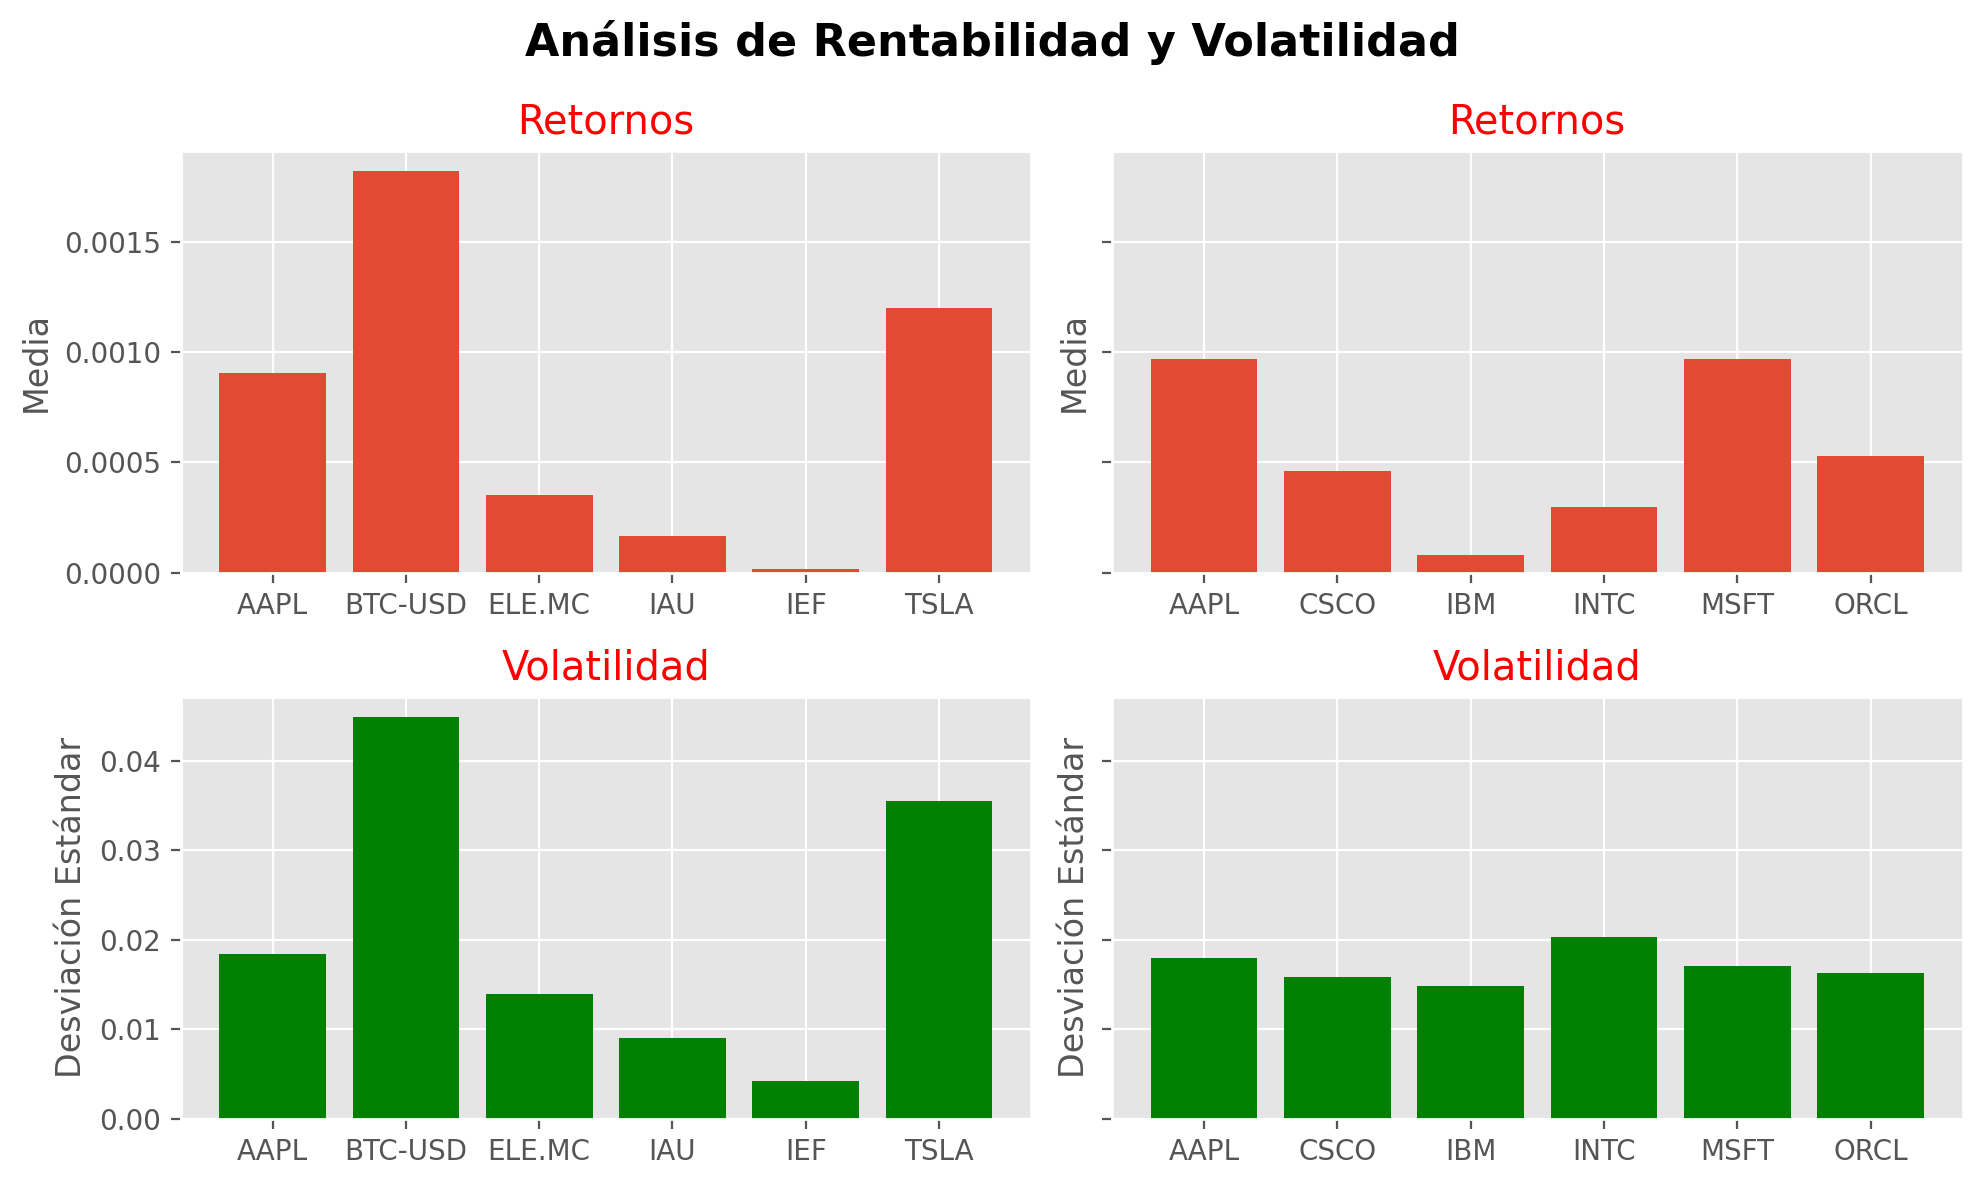

In [52]:
# Puedes calcular los valores medios y la desviación estándar de cada columna así:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Media')
axes[0, 0].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].set_title('Volatilidad')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Media')
axes[0, 1].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Desviación Estándar')
axes[1, 1].set_title('Volatilidad')

# Añadir un título general a la figura
plt.suptitle('Análisis de Rentabilidad y Volatilidad', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

También podemos verlo usando las gráficas de distribución de los retornos diarios de cada activo. Concretamente vamos a comparar la distribución de los retornos de `Bitcoin` frente a los `Bonos US`.

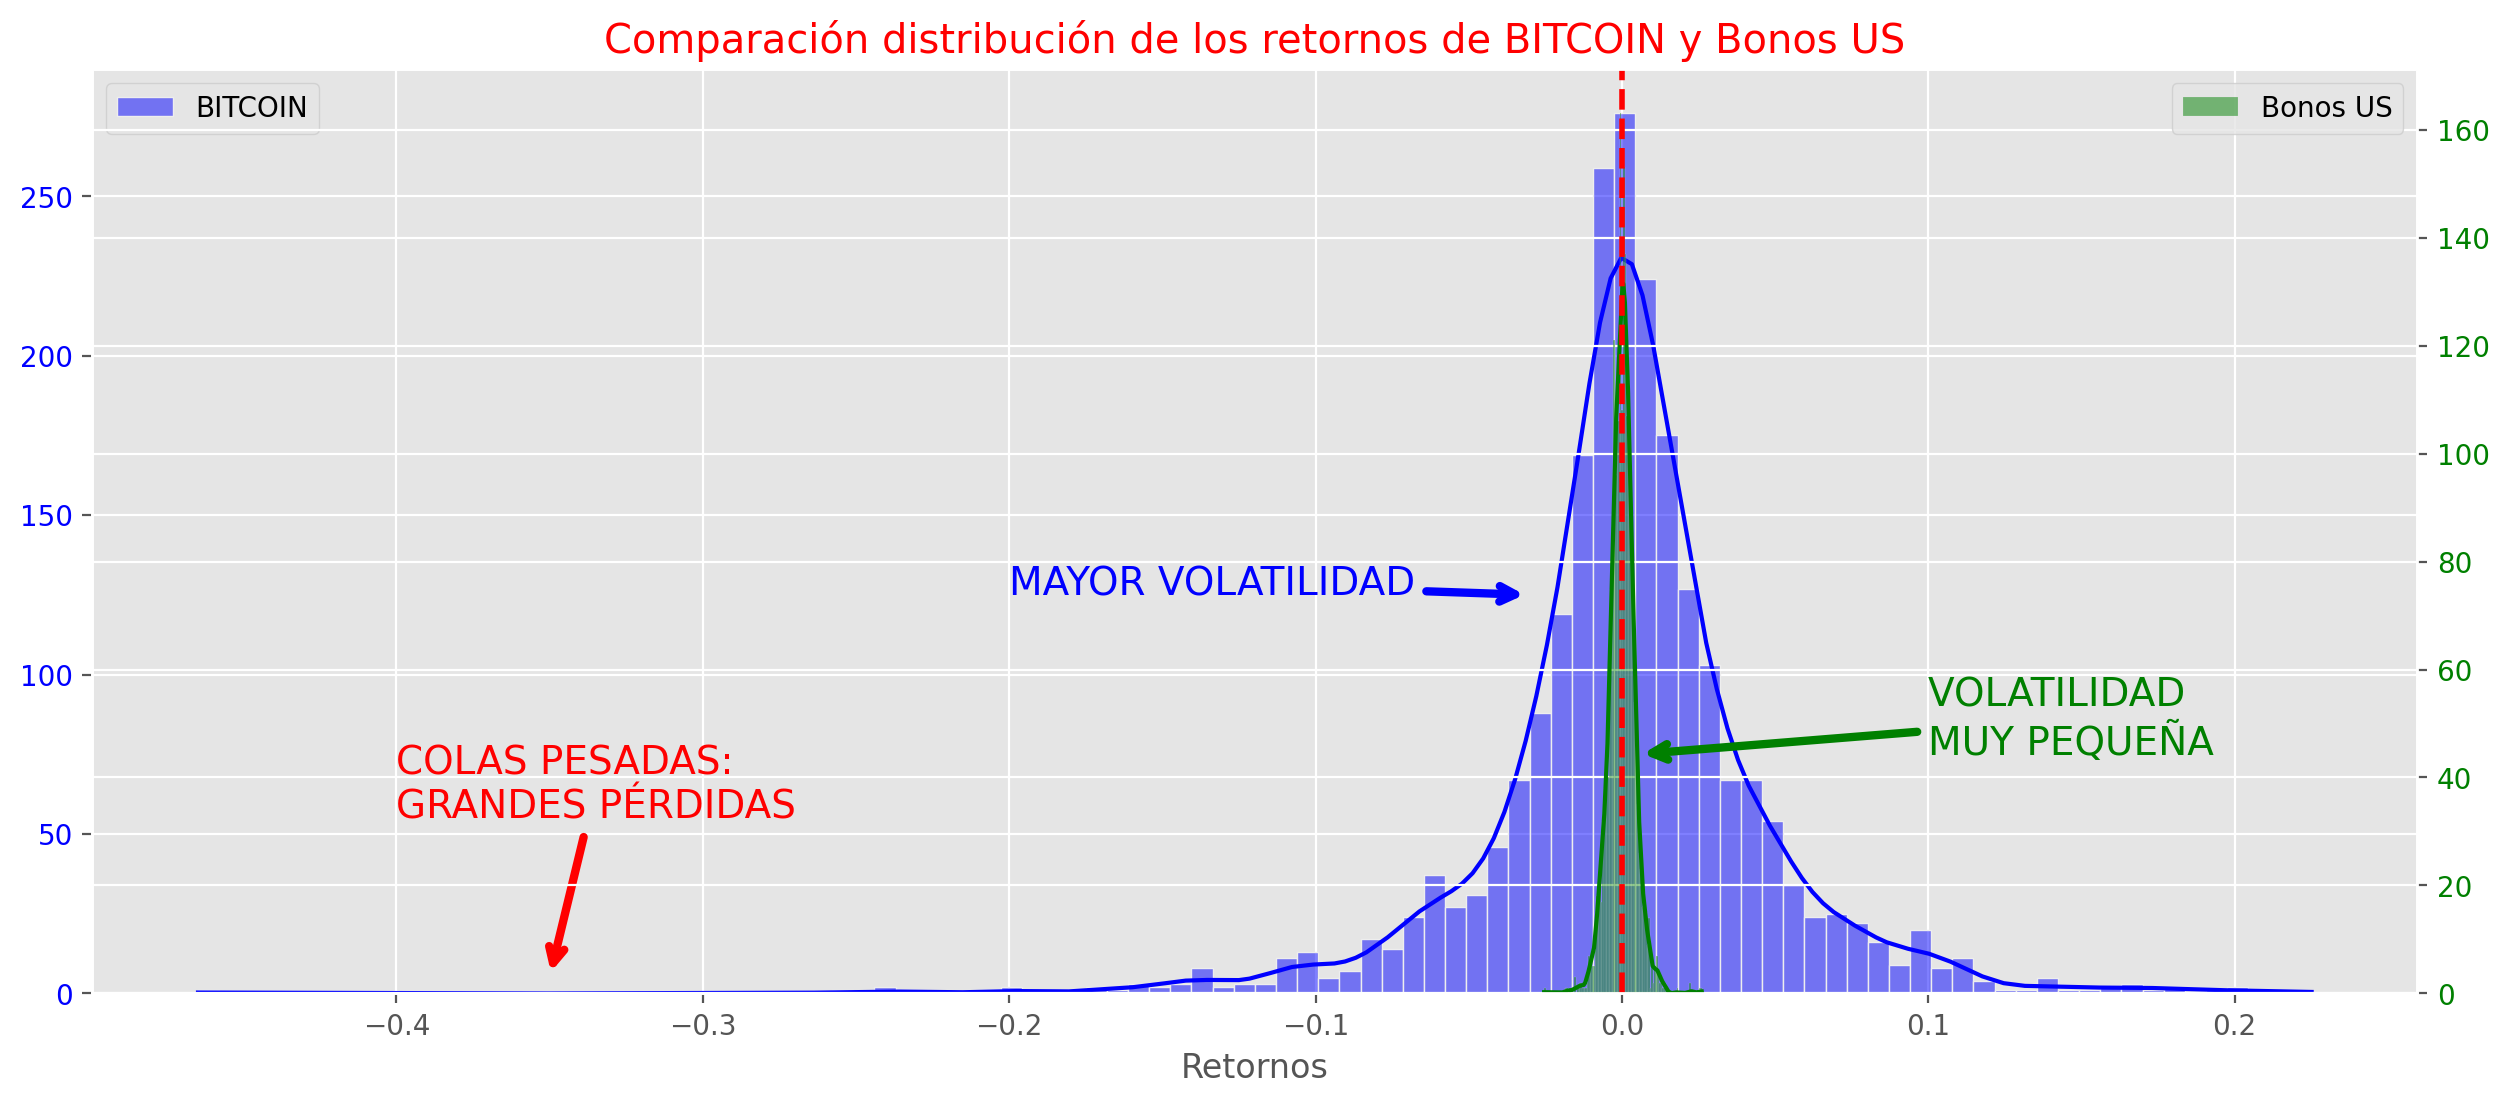

In [54]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# # Añadir texto en ax2
# text_x = -0.4
# text_y = 25

#ax1.text(-0.2, 125, f"MAYOR VOLATILIDAD", fontsize=12, color='blue')

ax1.annotate('MAYOR VOLATILIDAD', xy=(-0.03, 125), xytext=(-0.2, 125),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'),
            fontsize=14, color='blue')

ax1.annotate('VOLATILIDAD \nMUY PEQUEÑA', xy=(0.005, 75), xytext=(0.1, 75),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

ax1.annotate('COLAS PESADAS: \nGRANDES PÉRDIDAS', xy=(-0.35, 5), xytext=(-0.4, 55),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')



# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

Para poder analizar el comportamiento de un activo necesitamos la distribución de los retornos, pero en general se emplea solo la rentabilidad y el riesgo.

La teoría de que los activos se pueden caracterizar por el binomio rentabilidad-riesgo se cumple si:

* La función de utilidad del inversor es cuadrática. Fuera del scope de este curso.

* Los **retornos siguen una distribución normal**: Una normal se caracteriza por media y varianza.  

Vamos a comprobar si esta vez los retornos siguen una normal. Para comprobarlo, vamos a usar los retornos de `Bitcoin` y los vamos a comparar con una distribución normal (con la misma media y desviación estándar). Para ello, generamos unos datos sintéticos con distribución normal, media y desviación igual a la de los retornos de Bitcoin.

In [55]:
# Definir la media y la desviación estándar
media = ret_close_df['BTC-USD'].mean()
std = ret_close_df['BTC-USD'].std()

# Establecer la semilla (seed)
np.random.seed(3)  # Puedes usar cualquier número como semilla

# Generar una serie de números con distribución normal
data_norm = np.random.normal(media, std, 100000)  # 100000 números aleatorios

Usaremos los gráficos QQ-Plot para visualizar la distribución de los datos. Si los puntos se ajustan a la recta, los datos siguen una distribución normal.

Para más información sobre QQ-Plot pinchar [aquí](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

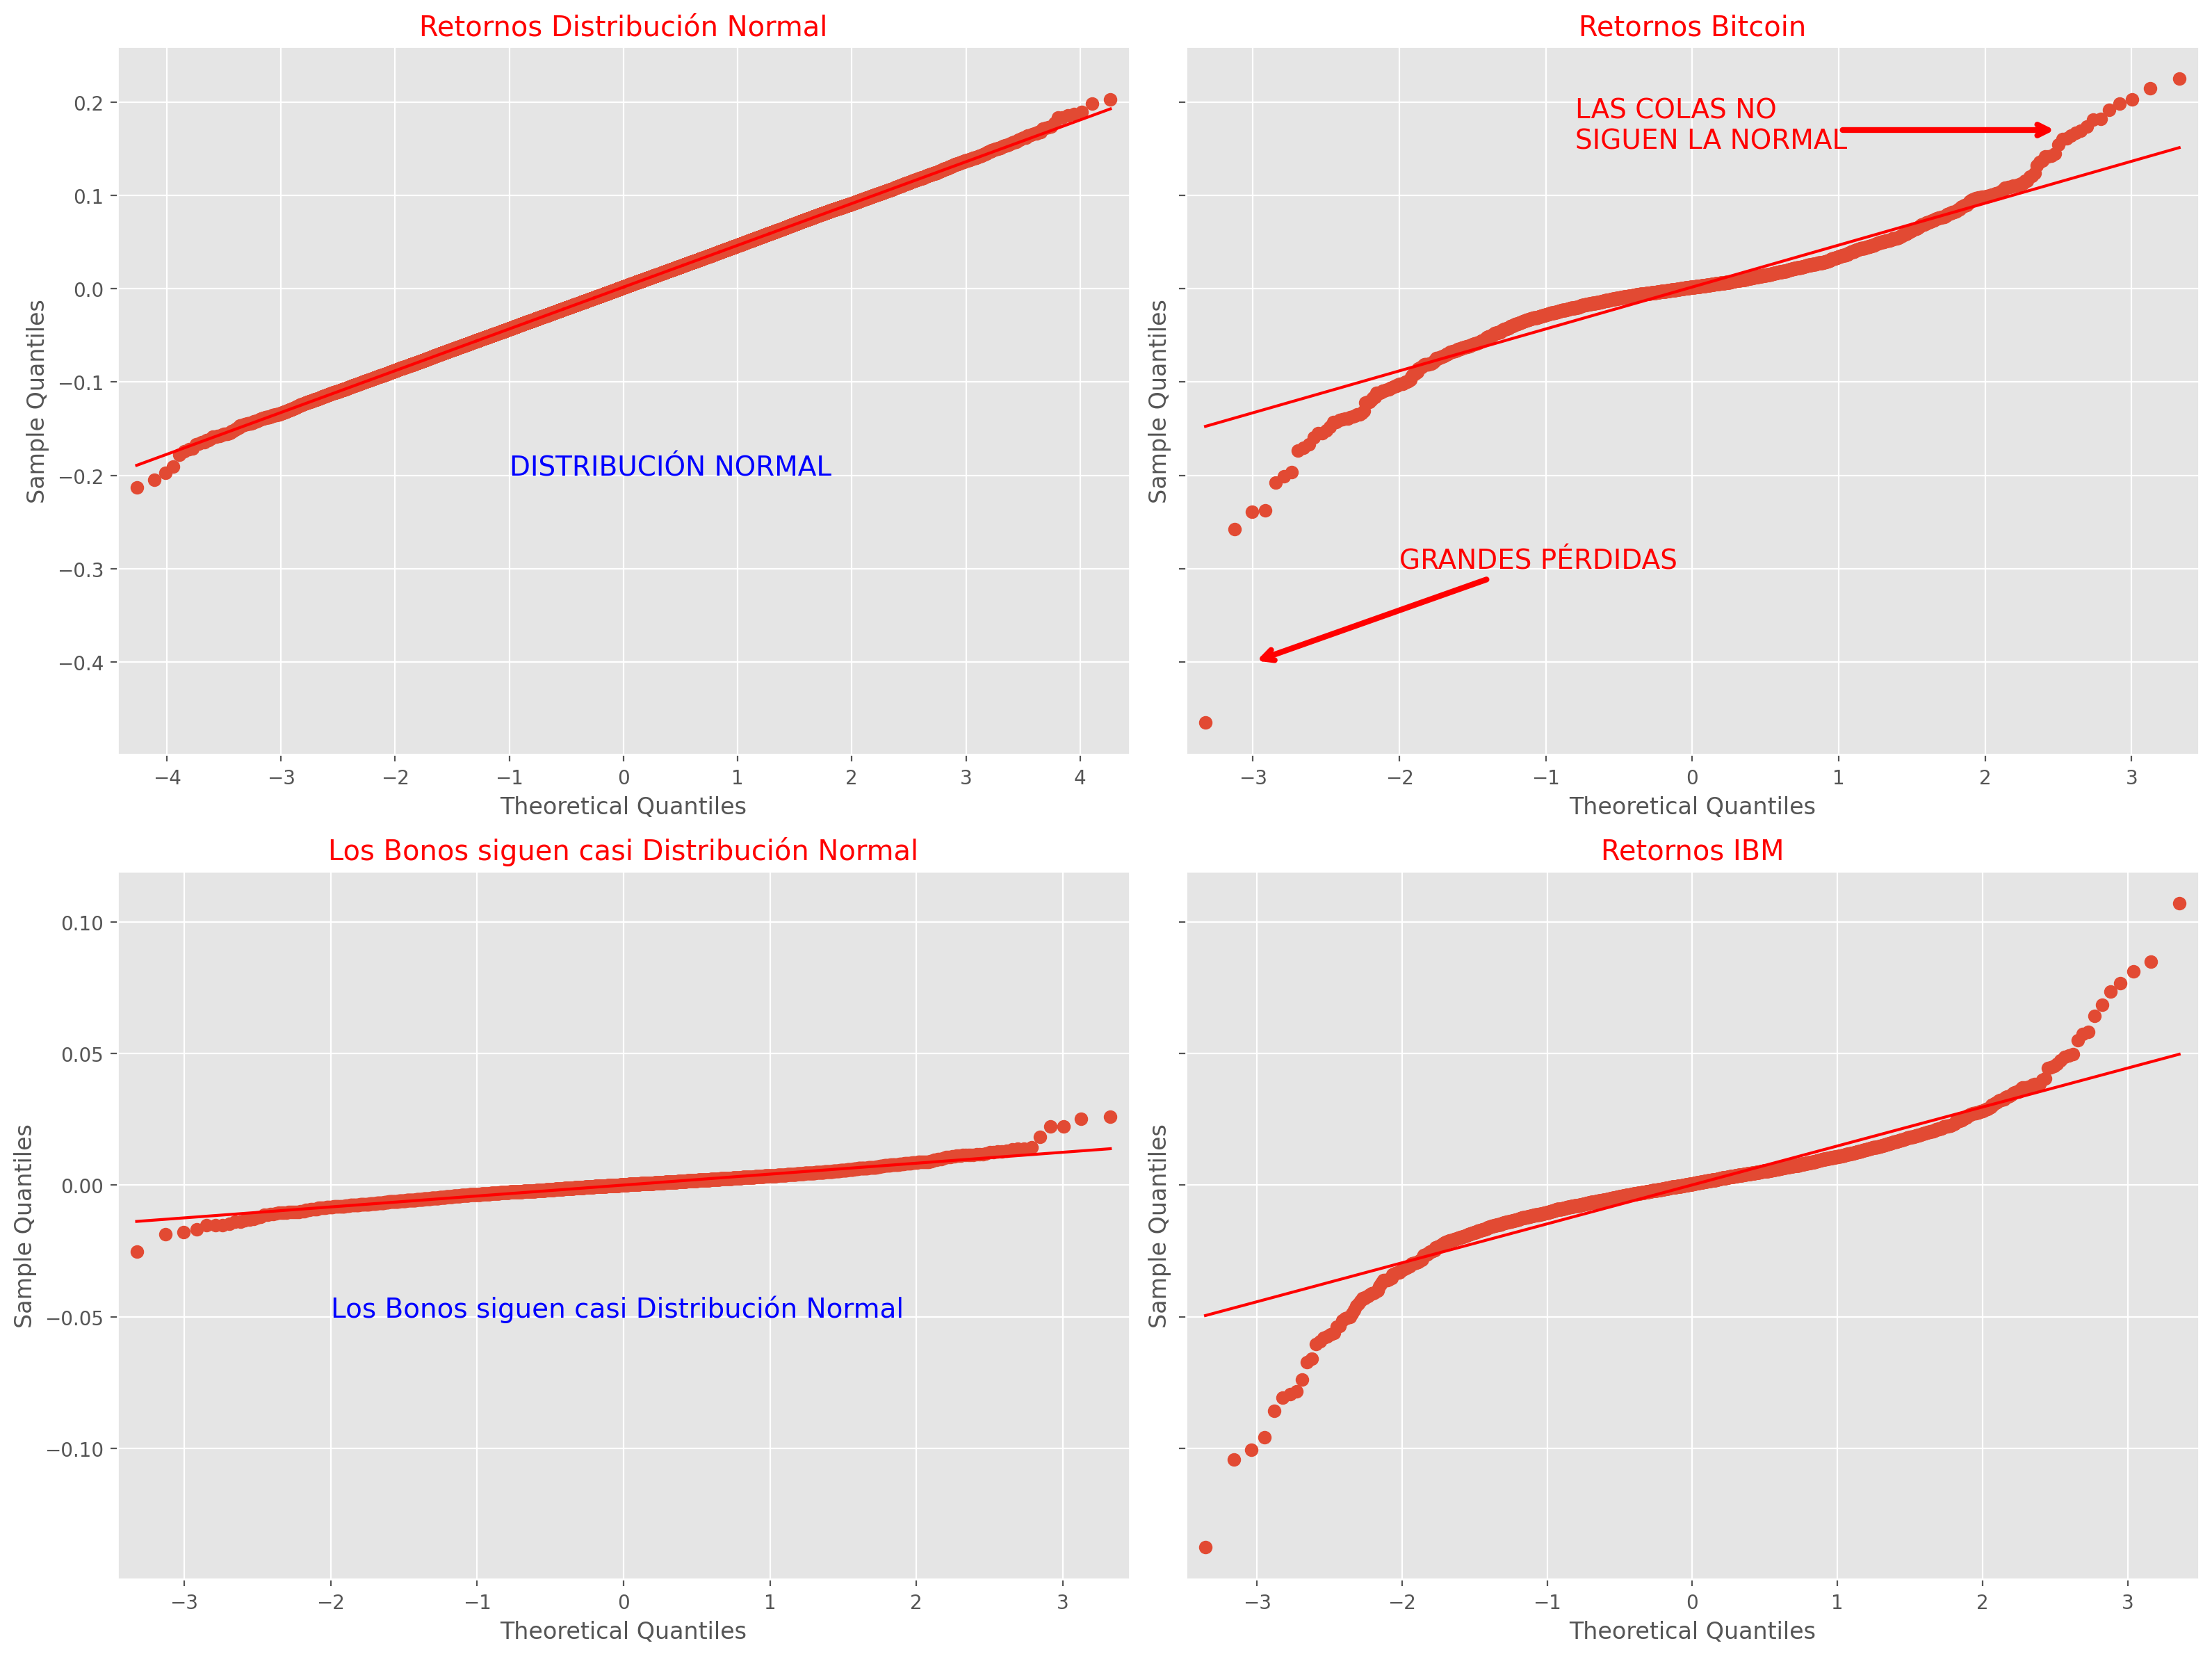

In [56]:
# Crear una figura con dos subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey='row')

# Graficar el primer histograma en el primer subplot
sm.qqplot(data_norm, line='s', ax=axs[0,0])
axs[0,0].set_title('Retornos Distribución Normal')

axs[0,0].text(-1, -0.2, "DISTRIBUCIÓN NORMAL", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['BTC-USD'], line='s', ax=axs[0,1])
axs[0,1].set_title('Retornos Bitcoin')

# Añadir texto en ax2
text_x = -3
text_y = -0.35

#axs[0,1].text(text_x, text_y, "GRANDES PÉRDIDAS", fontsize=14, color='RED')

text_x = -1.5
text_y = 0.15

axs[0,1].text(-0.8, 0.15, "LAS COLAS NO \nSIGUEN LA NORMAL", fontsize=14, color='RED')

axs[0,1].annotate("", xy=(2.5, 0.17), xytext=(1, 0.17),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Dibuja una flecha utilizando annotate
axs[0,1].annotate('GRANDES PÉRDIDAS', xy=(-3, -0.4), xytext=(-2, -0.3),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['IEF'], line='s', ax=axs[1,0])
axs[1,0].set_title('Retornos Bonos US')
axs[1,0].set_title('Los Bonos siguen casi Distribución Normal')
axs[1,0].text(-2, -0.05, "Los Bonos siguen casi Distribución Normal", fontsize=14, color='blue')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df_corr['IBM'], line='s', ax=axs[1,1])
axs[1,1].set_title('Retornos IBM')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Vamos a aplicar de nuevo el test de [Kolmogorov-Smirnov](https://es.wikipedia.org/wiki/Prueba_de_Kolmog%C3%B3rov-Smirnov) para comprobar si Bitcoin sigue una distribución normal (ya hemos visto que no).

In [57]:
# Prueba de Kolmogorov-Smirnov
stat, p = stats.kstest(ret_close_df['BTC-USD'], 'norm')

# Compara el valor p con un nivel de significancia (por ejemplo, 0.05)
alpha = 0.05
if p > alpha:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos SÍ SIGUEN una distribución normal (no podemos rechazar la hipótesis nula)")
else:
    print(f"El resultado es de {p:.4f}, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)")

El resultado es de 0.0000, lo que quiere decir que los datos NO SIGUEN una distribución normal (rechazamos la hipótesis nula)


**CONCLUSIÓN: LOS RETORNOS NO SIGUEN UNA DISTRIBUCIÓN NORMAL**

* Las colas de la distribución de los retornos son más pesadas que las de una distribución normal.

* Esto quiere decir que hay más probabilidad de que ocurran eventos extremos (tanto positivos como negativos) de lo que cabría esperar si los retornos siguieran una distribución normal.

* Por lo general, la cola izquierda es más pesada que la derecha, lo que quiere decir que hay más probabilidad de que ocurran eventos negativos extremos que positivos extremos.

**CONSECUENCIA: EL BINOMIO RENTABILIDAD-RIESGO NO ES SUFICIENTE PARA CARACTERIZAR LOS ACTIVOS**

Necesitamos más información para caracterizar los activos. Necesitamos conceptos como:

* Asimetría y curtosis

* VaR

* CVaR

* Drawdown

* Usar otras distribuciones de probabilidad (t-student, ...)

<hr>

### Análisis de otas medidas del riesgo

#### Asimetría o skewness

El skewness de los retornos de una acción es una medida de la asimetría de la distribución de los retornos de esa acción. 

La interpretación del skewness de los retornos de una acción es la siguiente:

* Un skewness positivo indica que la acción tiene una mayor probabilidad de generar ganancias que pérdidas.

* Un skewness negativo indica que la acción tiene una mayor probabilidad de generar pérdidas que ganancias.

* Un skewness neutro indica que la acción tiene una probabilidad igual de generar ganancias que pérdidas.

<center>
    <img src="../imgs/skewness.PNG"  alt="drawing" width="500">
</center>

Analicemos el skewness de los retornos de los activos que tenemos.

Si los retornos siguieran una distribución normal, el skewness debería ser 0.

In [ ]:
df_skew = ret_close_df.skew()
df_corr_skew = ret_close_df_corr.skew()

In [ ]:
# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0].bar(df_skew.index.values, df_skew.values)
axes[0].set_ylabel('Skew')
axes[0].set_title('')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1].bar(df_corr_skew.index.values, df_corr_skew.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')


# Añadir un título general a la figura
plt.suptitle('Análisis de Skweness', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<hr>

#### Curtosis o kurtosis

La curtosis es una medida de la forma de la distribución de los retornos de una acción. Se puede pensar en la curtosis como una medida de la "punta" de la distribución. Una distribución con curtosis alta tiene una "punta" más pronunciada que la distribución normal

La interpretación de la curtosis de los retornos de una acción es la siguiente:

* Una curtosis **igual a 3** indica que os retornos siguen una **distribución normal**.

* Una curtosis **mayor que 3** indica que la acción tiene una **mayor probabilidad de generar retornos extremos**, ya sean positivos o negativos.

* Una curtosis **menor que 3** indica que la acción tiene una **menor probabilidad de generar retornos extremos**.

In [58]:
df_curto = ret_close_df.kurtosis()
df_corr_curto = ret_close_df_corr.kurtosis()

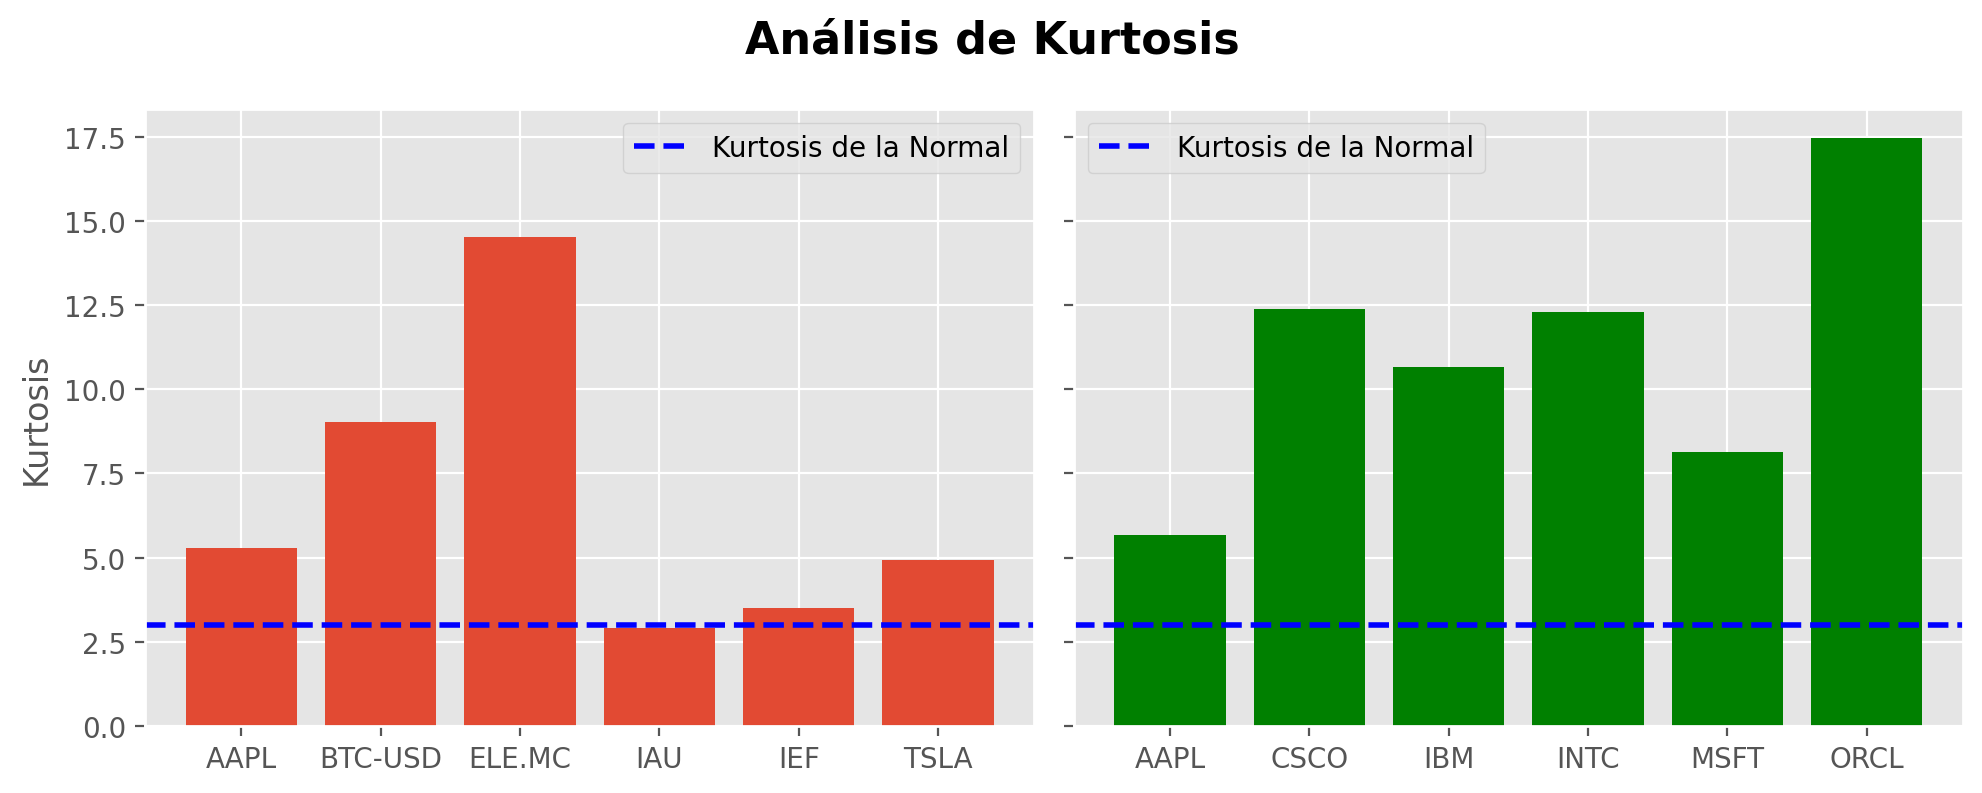

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')
axes[0].bar(df_curto.index.values, df_curto.values)
axes[0].set_ylabel('Kurtosis')
axes[0].set_title('')
axes[1].bar(df_corr_curto.index.values, df_corr_curto.values ,color='green')
axes[1].set_ylabel('')
axes[1].set_title('')
axes[0].axhline(y=3, color='blue', linestyle='--', linewidth=2, label='Kurtosis de la Normal')
axes[0].legend(loc='upper right')

axes[1].axhline(y=3, color='blue', linestyle='--', linewidth=2, label='Kurtosis de la Normal')
axes[1].legend(loc='upper left')
plt.suptitle('Análisis de Kurtosis', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

Veamos el impacto de la curtosis en la distribución de los retornos.

Recordad que valores altos de curtosis indican probabilidad de retornos extremos, por lo general grandes pérdidas.

Vamos a graficar la distribución de los retornos de un activo con un valor alto de curtosis y otro con un valor bajo de curtosis.

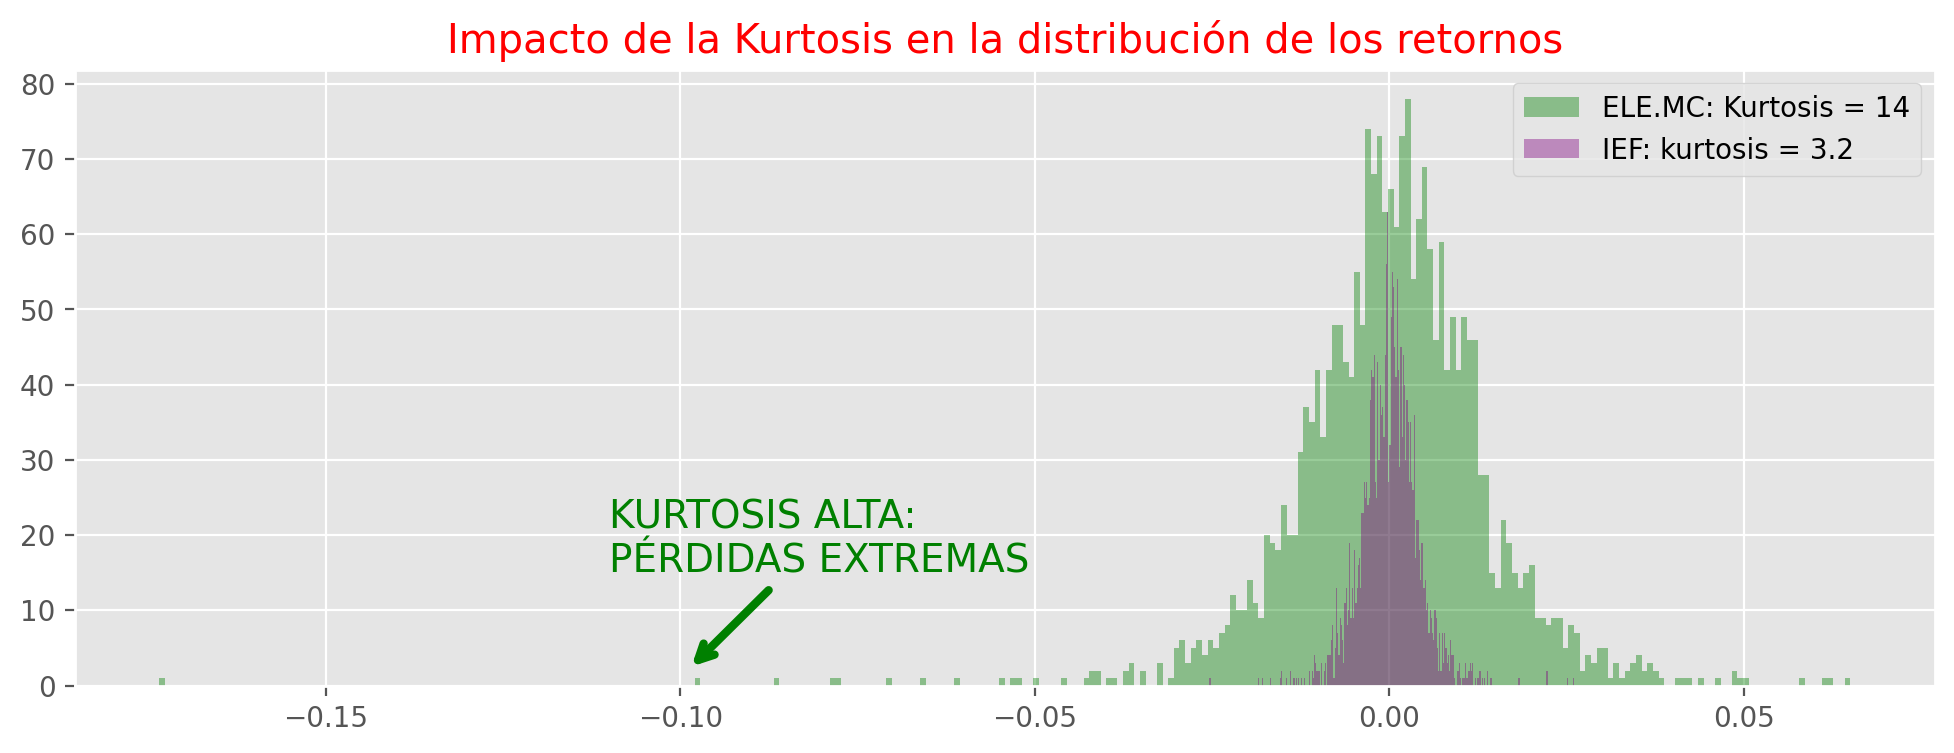

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.hist(ret_close_df['ELE.MC'], bins=300, color='green', alpha=0.4, label='ELE.MC: Kurtosis = 14')
#plt.hist(ret_close_df_corr['ORCL'], bins=300, color='green', alpha=0.4, label='ORCL')
plt.hist(ret_close_df['IEF'], bins=300, color='purple', alpha=0.4, label='IEF: kurtosis = 3.2')

# Dibuja una flecha utilizando annotate
ax.annotate('KURTOSIS ALTA:\nPÉRDIDAS EXTREMAS', xy=(-0.099, 2), xytext=(-0.11, 15),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

plt.title('Impacto de la Kurtosis en la distribución de los retornos')
plt.legend()
plt.show()  

<hr>

#### VaR

El Valor en Riesgo (VaR) es una medida del riesgo de mercado de un activo o una cartera de activos. Se define como la pérdida máxima que se espera que un activo o una cartera de activos sufra en un período de tiempo determinado con un cierto nivel de confianza.

Por ejemplo, si el VaR de una acción es de 100 de euros con un nivel de confianza del 95%, esto significa que hay un 95% de probabilidad de que la acción pierda menos de 100 euros en un período de tiempo determinado.

Para calcular el VaR existen tres métodos:

* **Método paramétrico**: Se asume que los retornos siguen una distribución normal.

* **Método no paramétrico**: Se calcula el VaR directamente a partir de los datos históricos.

* **Método de simulación**: Se simulan los retornos de la acción y se calcula el VaR a partir de los retornos simulados.

Primero vamos a ver el efecto en un activo cuya distribución de los retornos se parece a una normal. Luego, lo veremos en dos activos cuyas distribuciónes de los retornos no se parecen a una normal. Para ello, seguimos los siguientes pasos:

1. Calculamos los parámetros de la distribución de los retornos de cada activo: media y desviación estándar.

2. Calculamos el VaR de cada activo usando el método paramétrico y el método no paramétrico.

3. Graficamos la distribución de los retornos de cada activo y el VaR calculado.

In [61]:
# 1. Calcula la media y la desviación estándar de los retornos de cada activo
mu_elec = ret_close_df['ELE.MC'].mean()
sigma_elec = ret_close_df['ELE.MC'].std()
mu_ief = ret_close_df['IEF'].mean()
sigma_ief = ret_close_df['IEF'].std()
mu_btc = ret_close_df['BTC-USD'].mean()
sigma_btc = ret_close_df['BTC-USD'].std()

In [62]:
# 2. Calcula el Var paramétrico y el Var histórico para un nivel de confianza del 95%
confianza = 0.95

# Calcular el VaR usando el método de la distribución normal
varn_95_ele = stats.norm.ppf(1 - confianza, mu_elec, sigma_elec)
varn_95_ief = stats.norm.ppf(1 - confianza, mu_ief, sigma_ief)
varn_95_btc = stats.norm.ppf(1 - confianza, mu_btc, sigma_btc)

# Calcular el VaR usando el método histórico
var_95_ele = np.percentile(ret_close_df['ELE.MC'], 1 - confianza)
var_95_ief = np.percentile(ret_close_df['IEF'], 1 - confianza)
var_95_btc = np.percentile(ret_close_df['BTC-USD'], 1 - confianza)

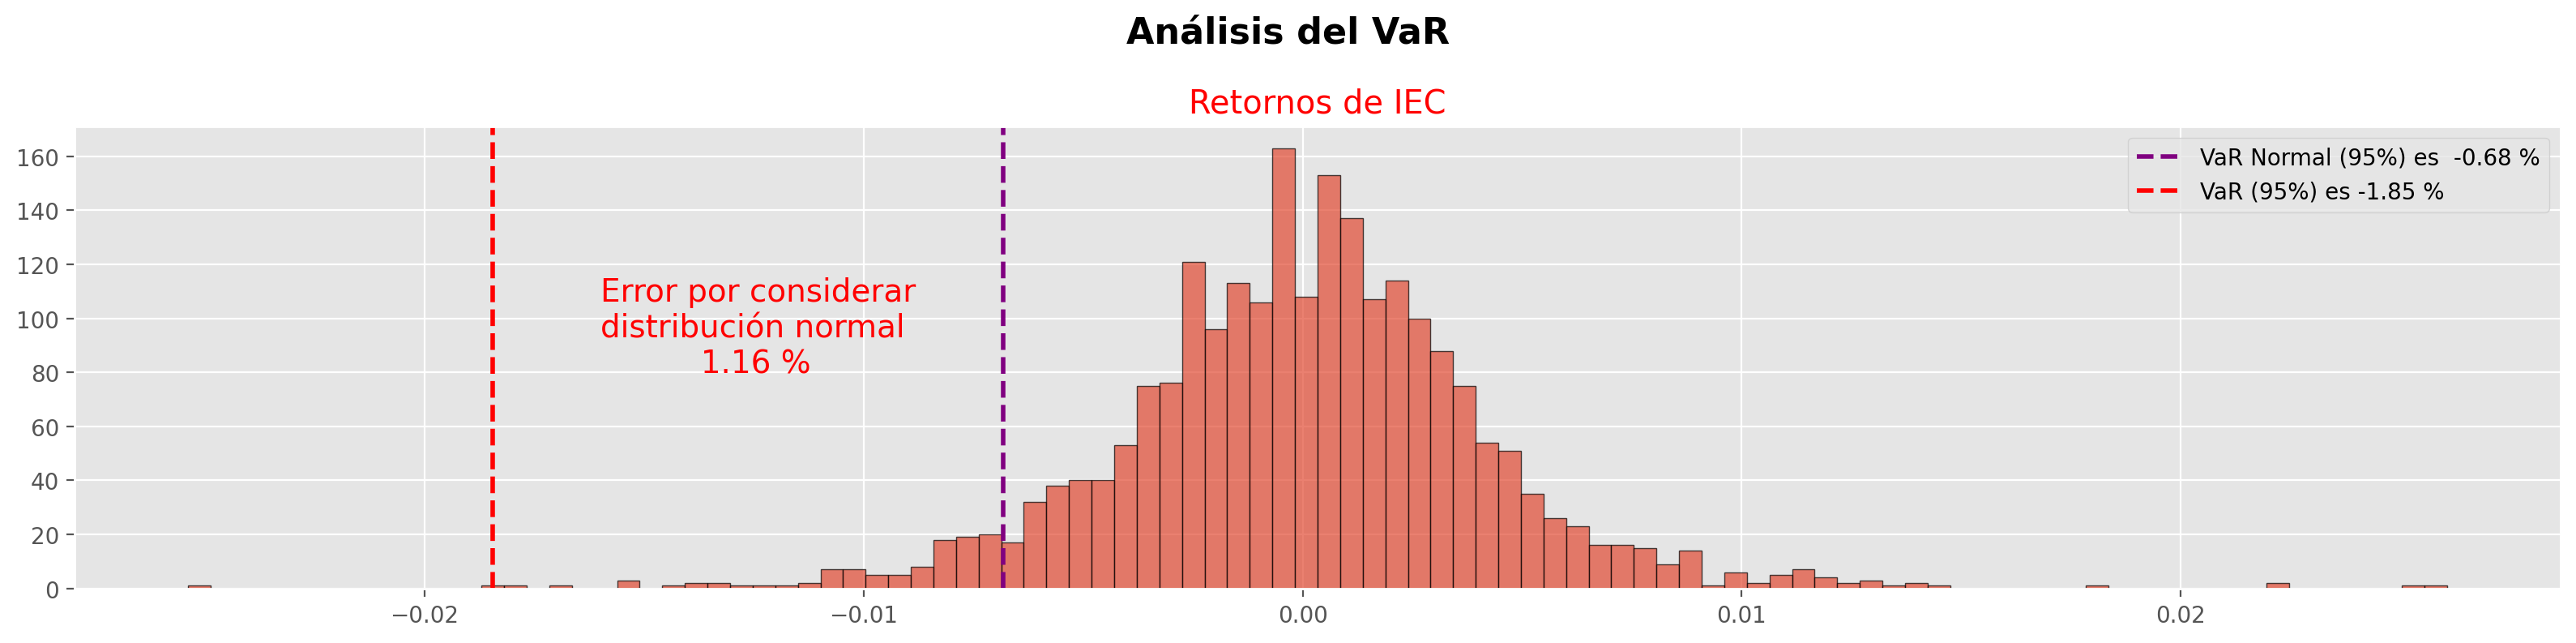

In [63]:
# 3. Hacemos la gráfica para un activo cua distribución de los retornos se parece a la normal IEF - Bonos US

fig, ax = plt.subplots(figsize=(16, 4))


ax.hist(ret_close_df['IEF'], bins=100, edgecolor='black', alpha=0.7)

ax.axvline(x=varn_95_ief, color='purple', linestyle='--', linewidth=2, label=f'VaR Normal (95%) es  {100 * varn_95_ief:.2f} %')
ax.axvline(x=var_95_ief, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ief:.2f} %')
ax.text(-0.016, 80, f"Error por considerar\ndistribución normal\n          {100 * np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=14, color='RED')

ax.set_ylabel('')
ax.set_title('Retornos de IEC')
ax.legend()


plt.suptitle('Análisis del VaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

INTERPRETACIÓN DE LA GRÁFICA:

1- El **Var Normal** es el VaR calculado usando el método paramétrico, es decir, asumiendo que los retornos siguen una distribución normal.

*  Var Normal nos dice que hay un 95% de probabilidad de que la acción pierda menos del 0.68% en un día.

2- El **Var Histórico** es el VaR calculado usando el método no paramétrico, es decir, usando los datos históricos.

* Var Histórico nos dice que hay un 95% de probabilidad de que la acción pierda menos del 1.85% en un día.

Es decir, cometemos un **error al calcular el riesgo del 1.16%** al asumir que los retornos siguen una distribución normal.

Pero, ¿qué ocurre si usamos activos cuyas distribuciones de los retornos no se parecen a una normal?

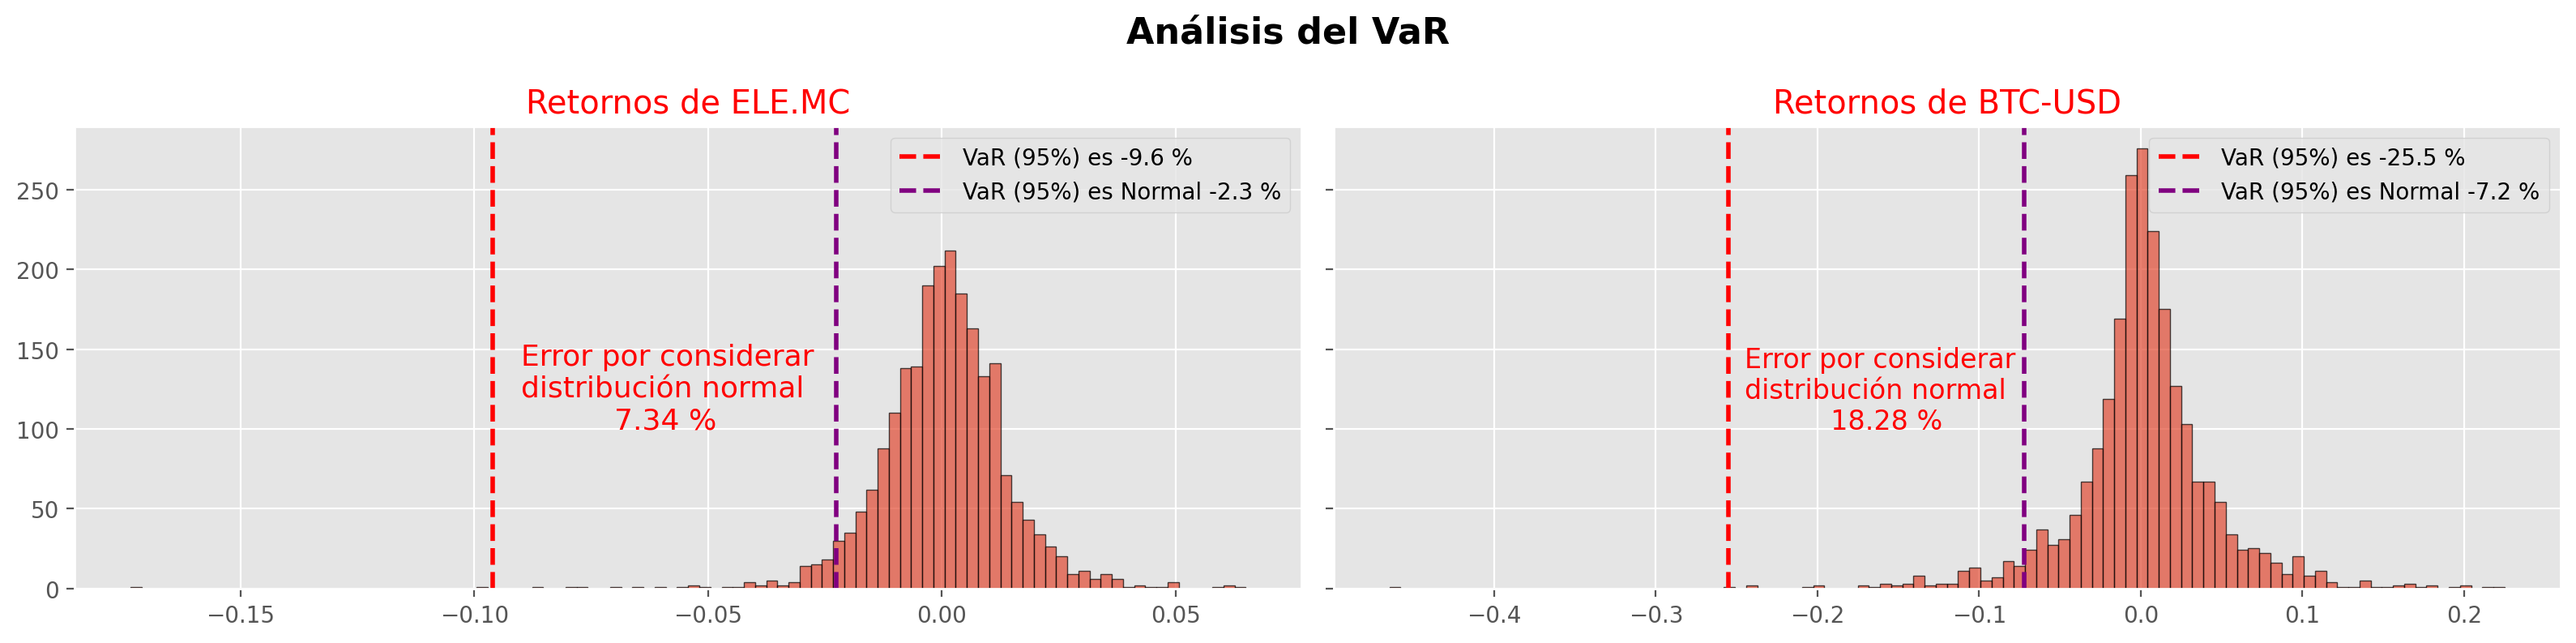

In [64]:
# 3. Hacemos la gráfica para dos activos cuyas distribuciones de los retornos NO se parece a la normal ELE-MC y BTC-USD

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey='row')
axes[0].hist(ret_close_df['ELE.MC'], bins=100, edgecolor='black', alpha=0.7)
#axes[0].axvline(x=var1_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var1_90:.1f} %')
axes[0].axvline(x=var_95_ele, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ele:.1f} %')
axes[0].axvline(x=varn_95_ele, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ele:.1f} %')
axes[0].text(-0.09, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ele-varn_95_ele):.2f} %", fontsize=13, color='RED')

axes[0].set_ylabel('')
axes[0].set_title('Retornos de ELE.MC')
axes[0].legend()

axes[1].hist(ret_close_df['BTC-USD'], bins=100, edgecolor='black', alpha=0.7)
#axes[1].axvline(x=var2_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var2_90:.1f} %')
axes[1].axvline(x=var_95_btc, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_btc:.1f} %')
axes[1].axvline(x=varn_95_btc, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_btc:.1f} %')
axes[1].text(-0.245, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_btc-varn_95_btc):.2f} %", fontsize=12, color='RED')

axes[1].set_ylabel('')
axes[1].set_title('Retornos de BTC-USD')
axes[1].legend()


plt.suptitle('Análisis del VaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

Es decir, cometemos un **error al calcular el riesgo del 7.34% y 18.28%**, respectivamente, al asumir que los retornos siguen una distribución normal.

<hr>

#### CVaR

+ El VaR tiene un problema: no considera cómo son los retornos que están por debajo del VaR. Es decir, dos activos pueden tener el mismo VaR pero uno puede tener retornos muy negativos y el otro no.

+ Para solucionar este problema se usa el CVaR o Conditional Value at Risk. El CVaR es la **media de los retornos que están por debajo del VaR**.

In [65]:
# Calcular el CVAR al 95%
cvar_95_ele = np.mean(ret_close_df['ELE.MC'][ret_close_df['ELE.MC'] < var_95_ele])
cvar_95_ief = np.mean(ret_close_df['IEF'][ret_close_df['IEF'] < var_95_ief])

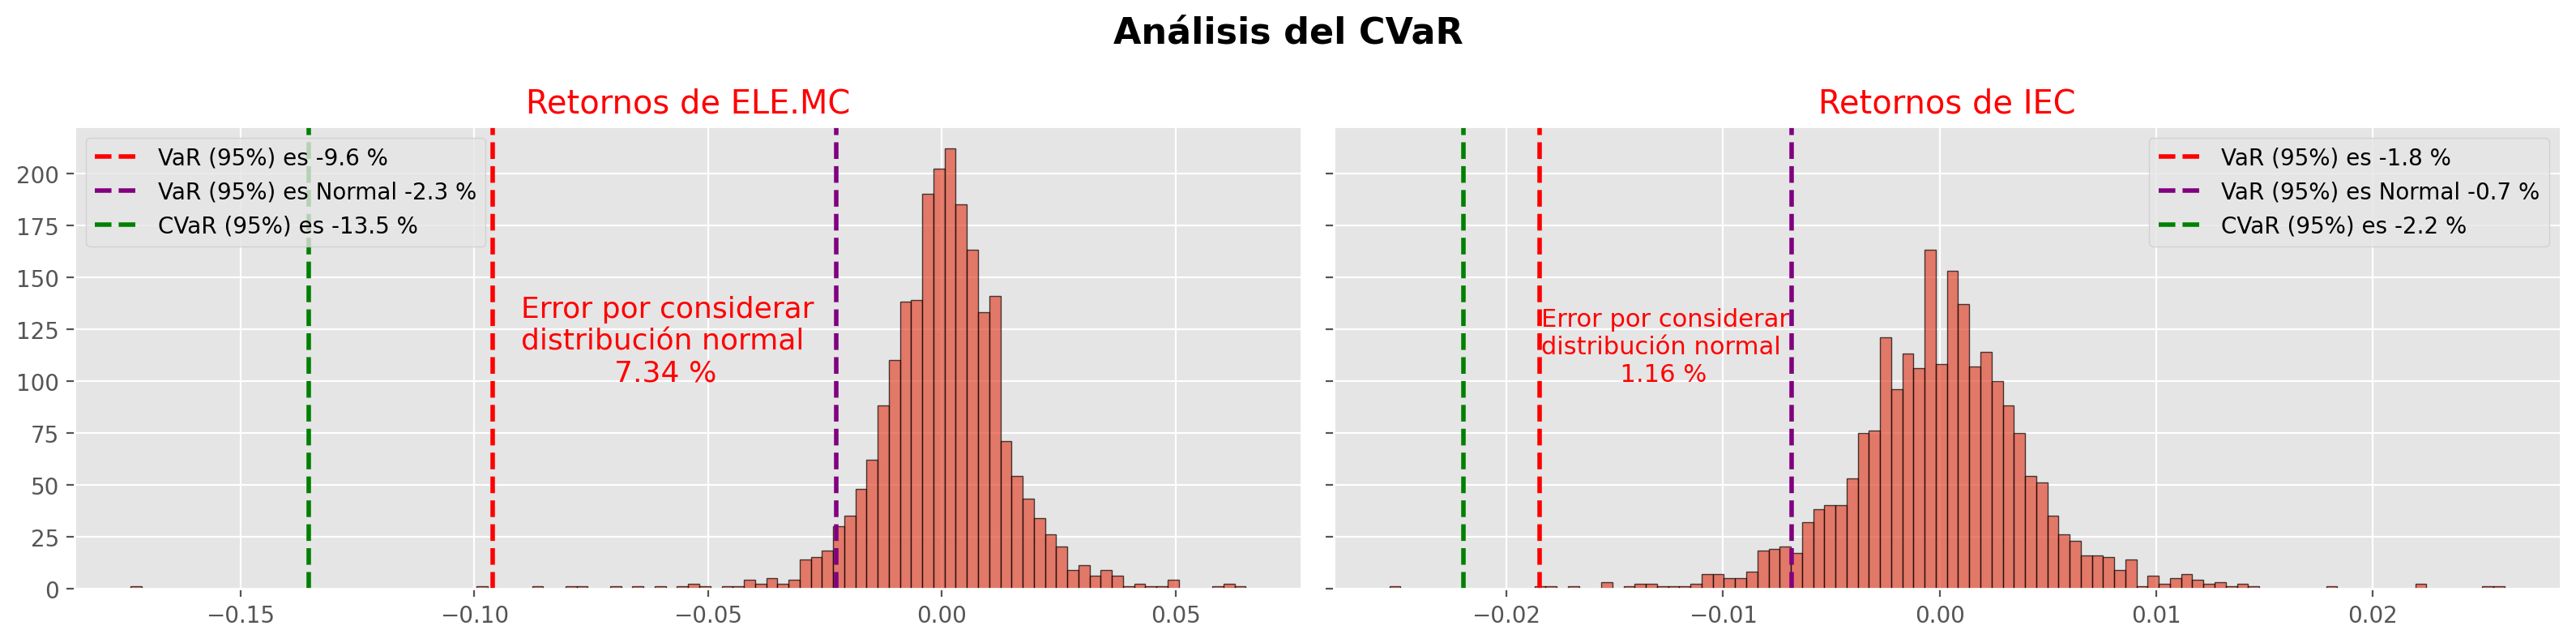

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey='row')
axes[0].hist(ret_close_df['ELE.MC'], bins=100, edgecolor='black', alpha=0.7)
#axes[0].axvline(x=var1_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var1_90:.1f} %')
axes[0].axvline(x=var_95_ele, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ele:.1f} %')
axes[0].axvline(x=varn_95_ele, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ele:.1f} %')
axes[0].text(-0.09, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ele-varn_95_ele):.2f} %", fontsize=13, color='RED')
axes[0].axvline(x=cvar_95_ele, color='green', linestyle='--', linewidth=2, label=f'CVaR (95%) es {100 * cvar_95_ele:.1f} %')

axes[0].set_ylabel('')
axes[0].set_title('Retornos de ELE.MC')
axes[0].legend()

axes[1].hist(ret_close_df['IEF'], bins=100, edgecolor='black', alpha=0.7)
#axes[1].axvline(x=var2_90, color='green', linestyle='--', linewidth=2, label=f'VaR (90%) es {100 * var2_90:.1f} %')
axes[1].axvline(x=var_95_ief, color='red', linestyle='--', linewidth=2, label=f'VaR (95%) es {100 * var_95_ief:.1f} %')
axes[1].axvline(x=varn_95_ief, color='purple', linestyle='--', linewidth=2, label=f'VaR (95%) es Normal {100 * varn_95_ief:.1f} %')
axes[1].text(-0.0184, 100, f"Error por considerar\ndistribución normal\n          {100 *np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=11, color='RED')
axes[1].axvline(x=cvar_95_ief, color='green', linestyle='--', linewidth=2, label=f'CVaR (95%) es {100 * cvar_95_ief:.1f} %')

axes[1].set_ylabel('')
axes[1].set_title('Retornos de IEC')
axes[1].legend()


plt.suptitle('Análisis del CVaR', fontsize=16)  # Título general
plt.tight_layout()
plt.show()

En términos más prácticos, el CVaR responde a la pregunta: **"Si la pérdida supera el VaR, ¿cuánto esperamos perder en promedio?"**

<hr>

#### Maximum Drawdown

Max Drawdown es una medida del riesgo en las finanzas que nos ayuda a entender cuánto se puede perder en una inversión o cartera en el peor momento antes de que empiece a recuperarse.

1. **Encuentra el punto más alto**: Identifica el valor máximo alcanzado por la inversión hasta un cierto instante de tiempo.

2. **Encuentra el punto más bajo mientras no se supere el máximo**: Desde el punto más alto encontrado en el paso 1, busca el valor más bajo que alcanzó la inversión mientras no se haya superado ese máximo. Este valor más bajo representa la mayor caída o drawdown.

3. **Calcula el drawdown máximo**: Resta el valor más bajo del punto más alto encontrado en el paso 1. El resultado es el drawdown máximo

4. **Reinicia el cálculo después de superar el punto más alto**: Después de que el valor de la inversión supere el punto más alto anterior (el máximo registrado), comienza un nuevo cálculo de drawdown máximo. Esto significa que cualquier pérdida anterior se considera parte del drawdown pasado, y se inicia un nuevo registro del drawdown a partir del nuevo punto más alto.

El drawdown máximo evoluciona a medida que la inversión alcanza nuevos máximos. 

Vamos a calcular el Max Drawdown de un activo.

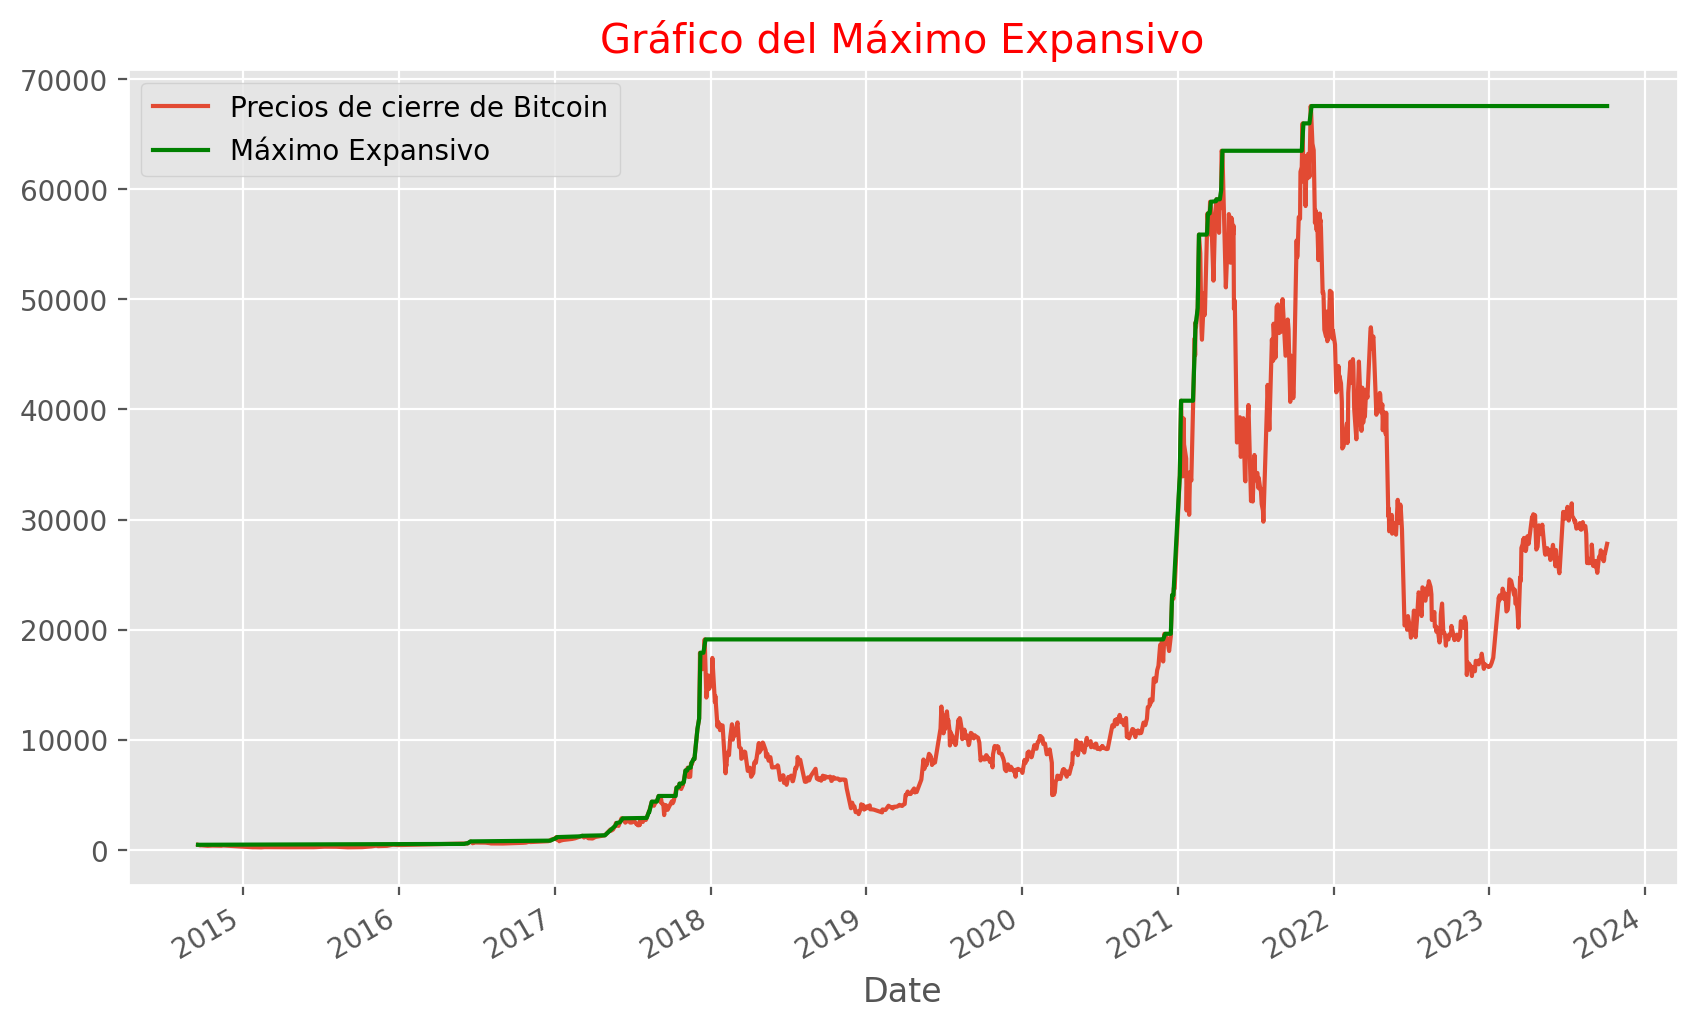

In [67]:
expanding_max = data_close_df["BTC-USD"].expanding().max()

fig, ax = plt.subplots(figsize=(10, 6))

data_close_df["BTC-USD"].plot(label='Precios de cierre de Bitcoin');
expanding_max.plot(label='Máximo Expansivo', color='green');
plt.legend()
plt.title('Gráfico del Máximo Expansivo')
plt.show()

Ahora calculo el drawdown máximo de cada activo siguiendo la formula:

$$Drawdown = \frac{P_t - P_{max}}{P_{max}} = \frac{P_t}{P_{max}}-1$$

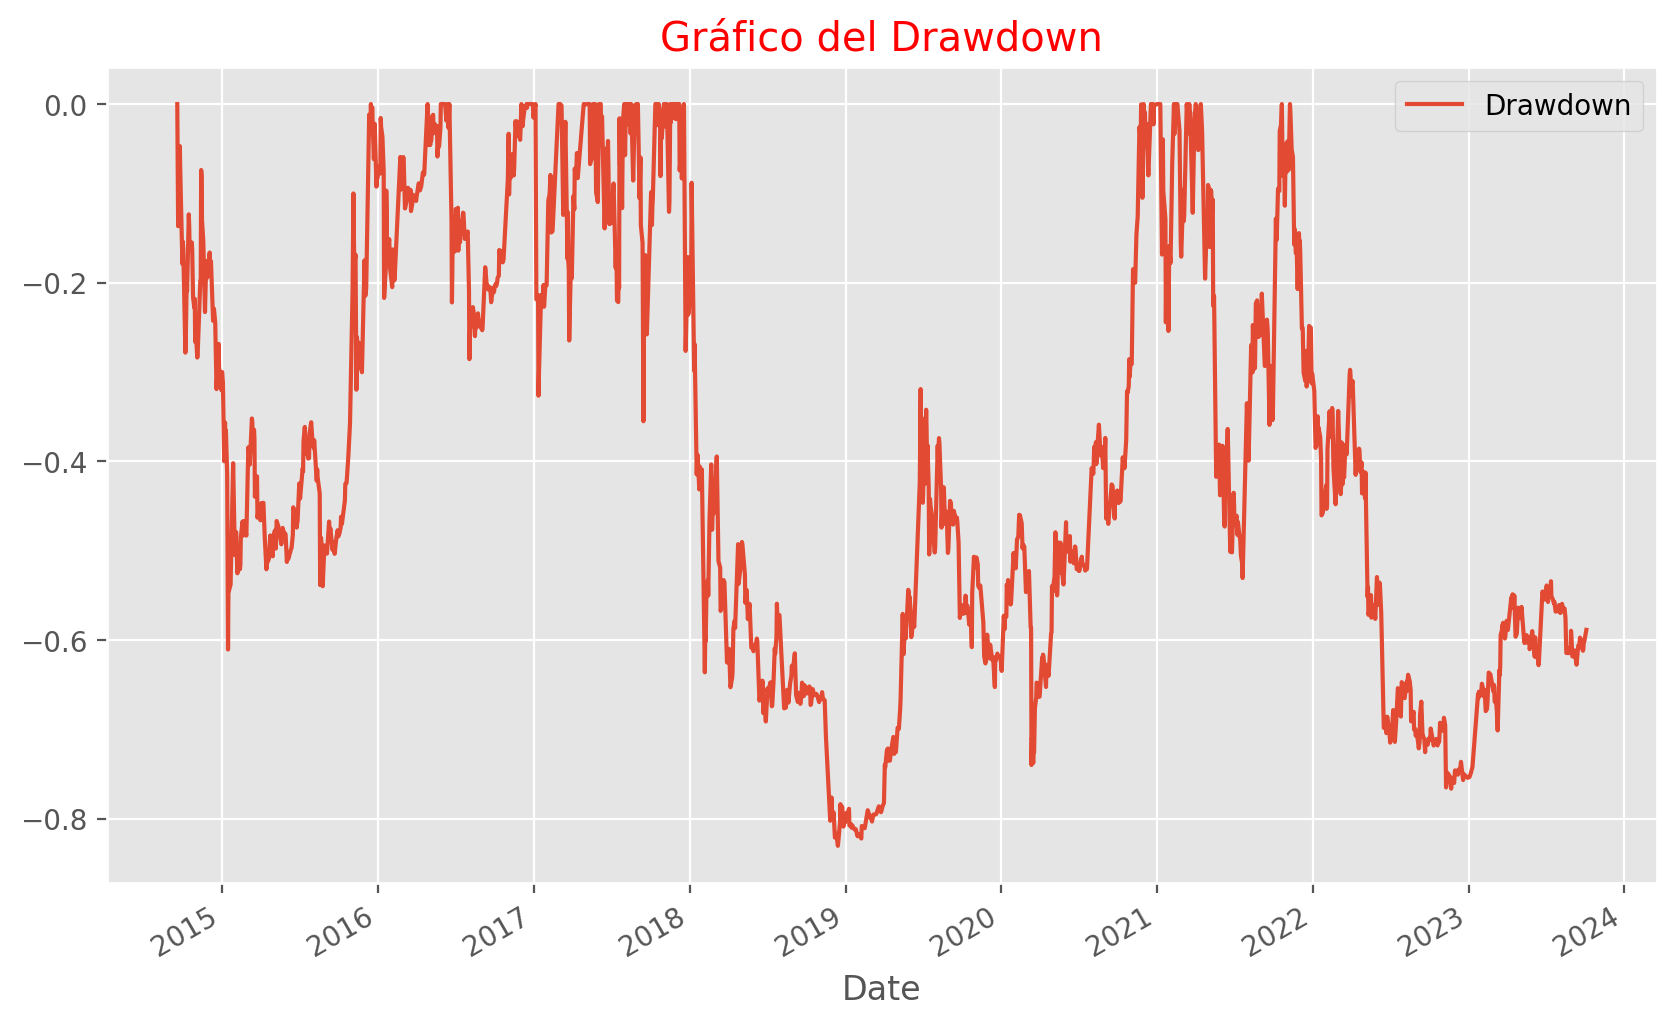

In [68]:
drawdown = data_close_df["BTC-USD"] / expanding_max - 1
drawdown.plot(label = 'Drawdown', figsize=(10, 6));
plt.legend()
plt.title('Gráfico del Drawdown');

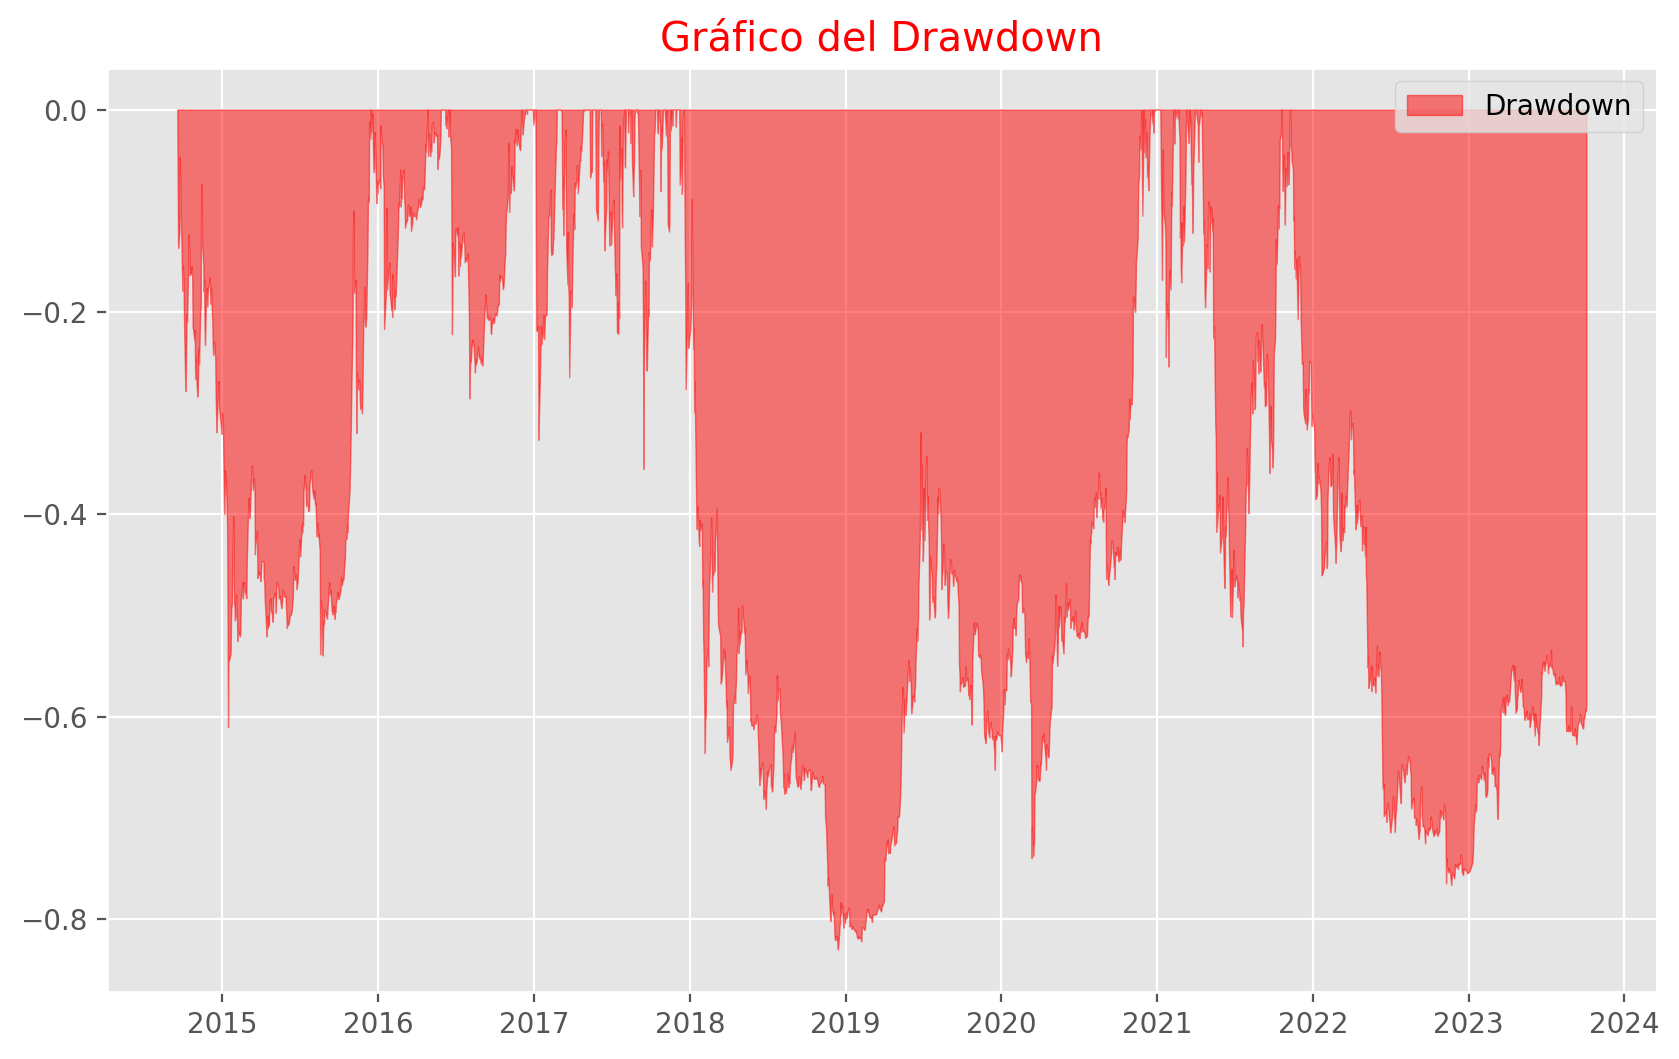

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.fill_between(data_close_df["BTC-USD"].index.values, drawdown, label='Drawdown', color='red', alpha=0.5);

plt.legend()
plt.title('Gráfico del Drawdown');

Podemos evaluar la duración de los periodos de drawdown

In [70]:
drawdown_per = expanding_max[expanding_max > expanding_max.shift(1)]

primer_valor = data_close_df["BTC-USD"].iloc[0]
primer_idx = data_close_df["BTC-USD"].index[0]

drawdown_per = pd.concat([pd.Series(primer_valor, index=[primer_idx]), drawdown_per])

drawdown_len = drawdown_per.index.to_series().diff().dt.days.shift(-1).fillna(0)

drawdown_len

2014-09-17    454.0
2015-12-15    133.0
2016-04-26     31.0
2016-05-27      4.0
2016-05-31      1.0
              ...  
2021-04-12      1.0
2021-04-13    189.0
2021-10-19      1.0
2021-10-20     19.0
2021-11-08      0.0
Length: 114, dtype: float64

<hr>

#### Distribución t-Student para los retornos

La distribución t-Student es una distribución de probabilidad que se usa para modelar la distribución de los retornos de los activos.

Las características de la distribución t-Student son:

* Tiene forma de campana simétrica, como la distribución normal.

* Tiene **colas más pesadas** que la distribución normal, es decir, hay más probabilidad de que ocurran eventos extremos.

* Tiene un parámetro adicional llamado grados de libertad. Cuantos más grados de libertad, más se parece a una distribución normal.


Veamos cómo se comportan los retornos de un activo con una distribución t-Student a la hora de calcular el VaR. Para ello, seguimos los siguientes pasos:

1. Calculamos los parámetros de la distribución de los retornos del activo: media y desviación estándar.

2. Calculamos el VaR del activo usando el método histórico

3. Calculamos el VaR usando la distribución normal y la t-Student.

4. Graficamos la distribución de los retornos del activo y los VaR calculados.

In [71]:
t_params_btc_auto = stats.t.fit(ret_close_df['BTC-USD'])
vart_95_btc_auto = stats.t.ppf(1 - confianza, *t_params_btc_auto)

In [72]:
confianza = 0.95

mu_btc = ret_close_df['BTC-USD'].mean()
sigma_btc = ret_close_df['BTC-USD'].std()

# Calcular el VaR usando el método histórico
var_95_btc = np.percentile(ret_close_df['BTC-USD'], 1 - confianza)

# Calcular el VaR usando el método de la distribución normal
varn_95_btc = stats.norm.ppf(1 - confianza, mu_btc, sigma_btc)

# Calcular el VaR usando el método de la distribución t-student
libertad_grad = 1 # libertad de grados. Cuántos menos grados, más pesadas las colas
t_params = (libertad_grad, mu_btc, sigma_btc) # parámetros de la distribución t-student
vart_95_btc = stats.t.ppf(1 - confianza, *t_params)

In [73]:
print(f"VaR t-student (95%) es {100 * vart_95_btc:.1f} %")
print(f"VaR normal (95%) es {100 * varn_95_btc:.1f} %")
print(f"VaR histórico (95%) es {100 * var_95_btc:.1f} %")

VaR t-student (95%) es -28.2 %
VaR normal (95%) es -7.2 %
VaR histórico (95%) es -25.5 %


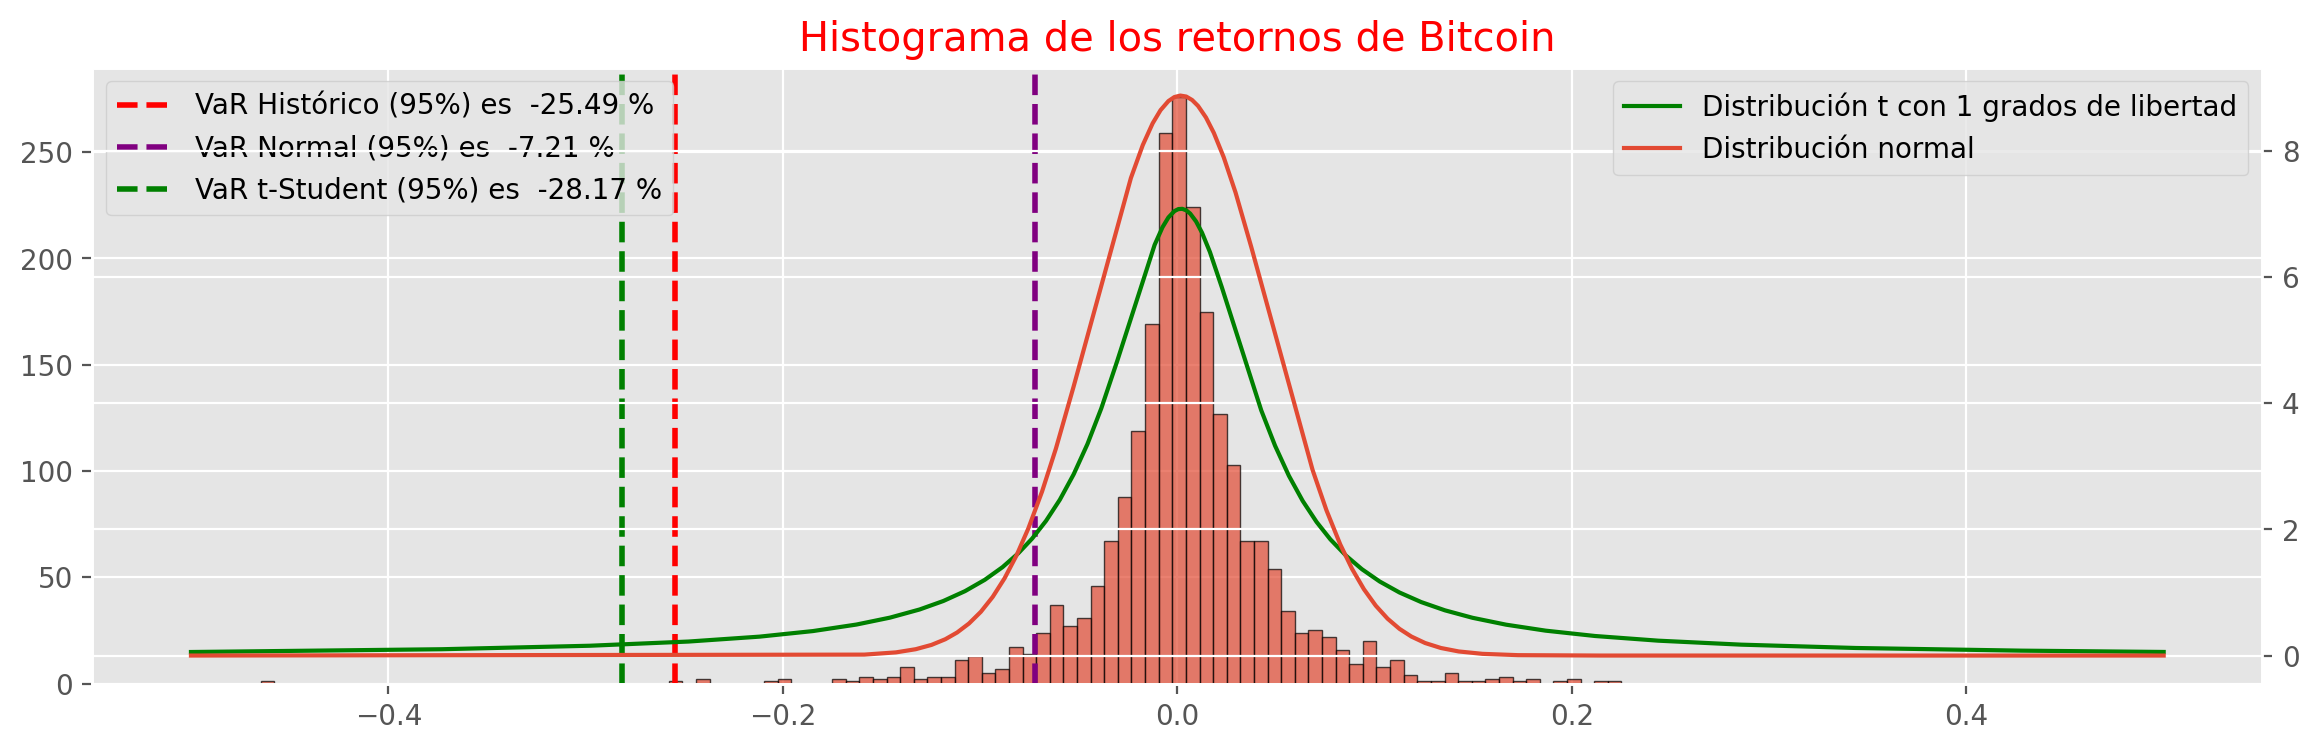

In [74]:
xmin = -0.5
xmax = 0.5
x = np.linspace(xmin, xmax, 1000)

t_pdf = stats.t.pdf(x, *t_params)
n_pdf = stats.norm.pdf(x, mu_btc, sigma_btc)

fig, ax = plt.subplots(figsize=(14, 4))

ax.hist(ret_close_df['BTC-USD'], bins=100, edgecolor='black', alpha=0.7)
plt.title('Histograma de los retornos de Bitcoin');

# Duplicar el eje Y para el segundo gráfico
ax2 = ax.twinx()

ax2.plot(x, t_pdf, color='green', label=f'Distribución t con {libertad_grad} grados de libertad')
ax2.plot(x, n_pdf, label='Distribución normal')
ax2.legend()

ax.axvline(x=var_95_btc, color='red', linestyle='--', linewidth=2, label=f'VaR Histórico (95%) es  {100 * var_95_btc:.2f} %')
ax.axvline(x=varn_95_btc, color='purple', linestyle='--', linewidth=2, label=f'VaR Normal (95%) es  {100 * varn_95_btc:.2f} %')
ax.axvline(x=vart_95_btc, color='green', linestyle='--', linewidth=2, label=f'VaR t-Student (95%) es  {100 * vart_95_btc:.2f} %')
ax.legend(loc='upper left')
#ax.text(-0.016, 80, f"Error por considerar\ndistribución normal\n          {100 * np.abs(var_95_ief-varn_95_ief):.2f} %", fontsize=14, color='RED')

#plt.legend()
plt.show()